In [11]:
import os
import numpy as np
from skimage import measure, morphology
from skimage.io import imsave
from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import display
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import os
from PIL import Image
from collections import Counter
from sklearn.cluster import KMeans

DEBUG = True

D1


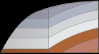

E1


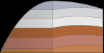

C1


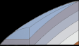

F1


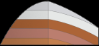

B1


G1


B2


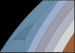

C2


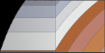

D2


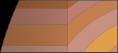

E2


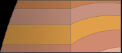

F2


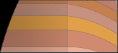

G2


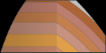

A2


H2


A3


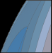

B3


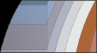

C3


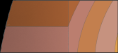

D3


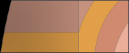

E3


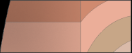

F3


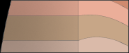

G3


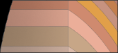

H3


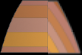

A4


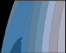

B4


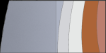

C4


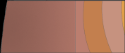

D4


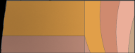

E4


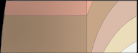

F4


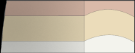

G4


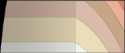

H4


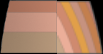

A5


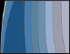

B5


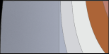

C5


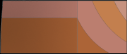

D5


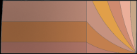

E5


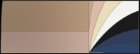

F5


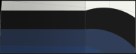

G5


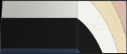

H5


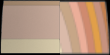

A6


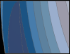

B6


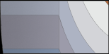

C6


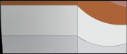

D6


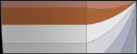

E6


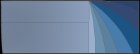

F6


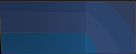

G6


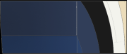

H6


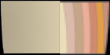

A7


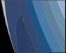

B7


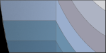

C7


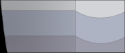

D7


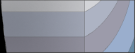

E7


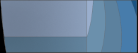

F7


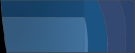

G7


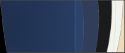

H7


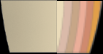

A8


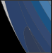

B8


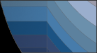

C8


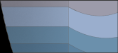

D8


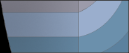

E8


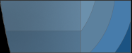

F8


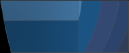

G8


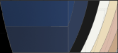

H8


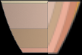

A9


B9


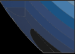

C9


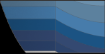

D9


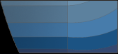

E9


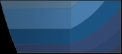

F9


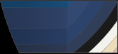

G9


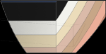

H9


B10


C10


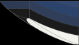

E10


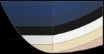

F10


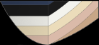

D10


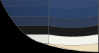

G10


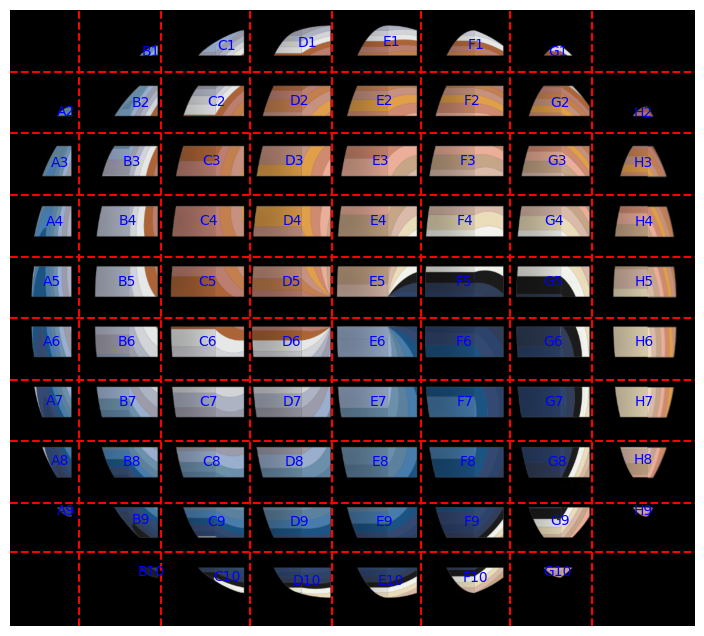

In [8]:

def overlay_and_save_regions(img_path, x_pct, y_pct, area_threshold=5, output_dir='./output'):
    # Load the image
    image = Image.open(img_path)
    image_array = np.array(image)

    # Ensure output directory exists
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Adjust for images with an alpha channel
    if image_array.shape[2] == 4:  # If RGBA, convert to RGB
        image_array = image_array[:, :, :3]

    # Convert to grayscale and create a binary mask
    grayscale = np.mean(image_array[:, :, :3], axis=2)
    mask = grayscale > 15  # Adjust the threshold as needed

    # Remove small objects from the mask
    mask_cleaned = morphology.remove_small_objects(mask, min_size=area_threshold)

    # Label the cleaned mask
    labeled_mask, _ = measure.label(mask_cleaned, background=0, return_num=True)

    # Prepare the image for drawing
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.imshow(image_array)

    # Image dimensions
    height, width = image_array.shape[:2]

    # Draw the grid
    for x_pct in x_pct:
        ax.axvline(x=x_pct / 100 * width, color='red', linestyle='--')
    for y_pct in y_pct:
        ax.axhline(y=y_pct / 100 * height, color='red', linestyle='--')

    # Dictionary to store region images
    region_images = {}

    # Process each region
    for region in measure.regionprops(labeled_mask):
        centroid_y, centroid_x = region.centroid
        # Determine grid cell for the centroid
        x_grid = [x / 100 * width for x in x_pct]
        y_grid = [y / 100 * height for y in y_pct]
        x_bounds = [0] + x_grid + [width]
        y_bounds = [0] + y_grid + [height]

        for i in range(len(x_bounds) - 1):
            for j in range(len(y_bounds) - 1):
                if x_bounds[i] <= centroid_x < x_bounds[i + 1] and y_bounds[j] <= centroid_y < y_bounds[j + 1]:
                    label = f'{chr(65 + i)}{j + 1}'  # Label as A1, B2, etc.
                    ax.text(centroid_x, centroid_y, label, color='blue', ha='center', va='center')

                    # Extract and save the region image
                    minr, minc, maxr, maxc = region.bbox
                    region_image = image_array[minr:maxr, minc:maxc]
                    region_images[label] = region_image

                    # Display the region image
                    if DEBUG:
                        print(label)
                        display(Image.fromarray(region_image))

                    # Save the region image to file
                    with Image.fromarray(region_image) as img:
                        img.save(f'temp/{label}.png')
                        pass
                    break

    ax.axis('off')
    plt.show()

    return region_images


# Updated grid lines based on manual adjustments
x_percent = [10, 22, 35, 47, 60, 73, 85]
y_percent = [10, 20, 30, 40, 50, 60, 70, 80, 88]

# Call the function and receive the cropped regions
cropped_regions = overlay_and_save_regions('crop.png', x_percent, y_percent, 5)

# Example: Access a specific cropped region by its label
# label = 'B2'  # Example label
# cropped_image = cropped_regions.get(label)
# if cropped_image is not None:
#     plt.imshow(cropped_image)
#     plt.axis('off')
#     plt.show()


In [22]:
# Define the directory containing the PNG files
directory = './temp'  # Update this path to your actual directory

# List and sort all PNG files in the directory
png_files = [f for f in os.listdir(directory) if f.endswith('.png')]
png_files.sort()  # Ensure files are sorted according to the naming convention

from sklearn.metrics import silhouette_score


def find_optimal_clusters(data, max_clusters=10):
    silhouette_scores = []
    for n_clusters in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=n_clusters, random_state=10)
        labels = kmeans.fit_predict(data)
        score = silhouette_score(data, labels)
        silhouette_scores.append(score)

    # Find the number of clusters with the highest silhouette score
    optimal_clusters = 2 + silhouette_scores.index(max(silhouette_scores))
    return optimal_clusters


def get_dominant_colors(img_path, max_clusters=15):
    # Load the image and preprocess as before
    image = Image.open(img_path)
    np_image = np.array(image)
    if np_image.shape[-1] == 4:
        np_image = np_image[..., :3]
    reshaped = np_image.reshape((-1, 3))
    non_black_pixels = np.array([pixel for pixel in reshaped if not np.all(pixel <= [15, 15, 15])])

    if len(non_black_pixels) == 0:
        return []

    # Find optimal number of clusters
    optimal_clusters = min(find_optimal_clusters(non_black_pixels, max_clusters), len(non_black_pixels))

    # Perform K-means clustering with optimal number of clusters
    kmeans = KMeans(n_clusters=optimal_clusters)
    kmeans.fit(non_black_pixels)
    cluster_centers = kmeans.cluster_centers_
    labels = kmeans.labels_

    # Count the pixels in each cluster and sort
    counts = Counter(labels)
    cluster_colors = [tuple(map(int, cluster_centers[i])) for i in counts.keys()]
    sorted_colors = sorted(zip(cluster_colors, counts.values()), key=lambda x: x[1], reverse=True)

    return sorted_colors


def plot_dominant_colors(colors):
    colors = [color[0] for color in colors]  # RGB values
    counts = [color[1] for color in colors]  # Pixel counts
    plt.figure(figsize=(10, 6))
    bars = plt.bar(range(len(colors)), counts, color=[np.array(c) / 255.0 for c in colors])
    plt.xticks(range(len(colors)), [str(c) for c in colors], rotation='vertical')
    plt.xlabel('Color (R, G, B)')
    plt.ylabel('Pixel Count')

    # Load the image to be used as an inset
    img = Image.open(image_path)
    img_array = np.array(img)

    # Create an inset_axes instance in the current figure (top right corner)
    ax_inset = inset_axes(plt.gca(), width="30%", height="30%", loc='upper right')
    ax_inset.imshow(img_array)
    ax_inset.axis('off')  # Hide the axis of the inset

    plt.show()
    


with open(f'data.txt', 'w') as f:
    for png_file in png_files:
        image_path = os.path.join(directory, png_file)

        # Get the dominant colors for the current image
        dominant_colors = get_dominant_colors(image_path)

        # Plot dominant colors as bar plot
        # if DEBUG:
        #     plot_dominant_colors(dominant_colors)

        # save dominant colors to file

        for color in dominant_colors:
            f.write(f'{color[0]}')
        f.write('\n')
        print(png_file)


A2.png
A3.png
A4.png
A5.png
A6.png
A7.png
A8.png
A9.png
B1.png
B10.png
B2.png
B3.png
B4.png
B5.png
B6.png
B7.png
B8.png
B9.png
C1.png
C10.png
C2.png
C3.png
C4.png
C5.png
C6.png
C7.png
C8.png
C9.png
D1.png
D10.png
D2.png
D3.png
D4.png
D5.png
D6.png
D7.png
D8.png
D9.png
E1.png
E10.png
E2.png
E3.png
E4.png
E5.png
E6.png
E7.png
E8.png
E9.png
F1.png
F10.png
F2.png
F3.png
F4.png
F5.png
F6.png
F7.png
F8.png
F9.png
G1.png
G10.png
G2.png
G3.png
G4.png
G5.png
G6.png
G7.png
G8.png
G9.png
H2.png
H3.png
H4.png
H5.png
H6.png
H7.png
H8.png
H9.png


offset, thickness, direction
0.7, 1.0, -1.0
offset, thickness, direction
0.0, 1.0, 1.0


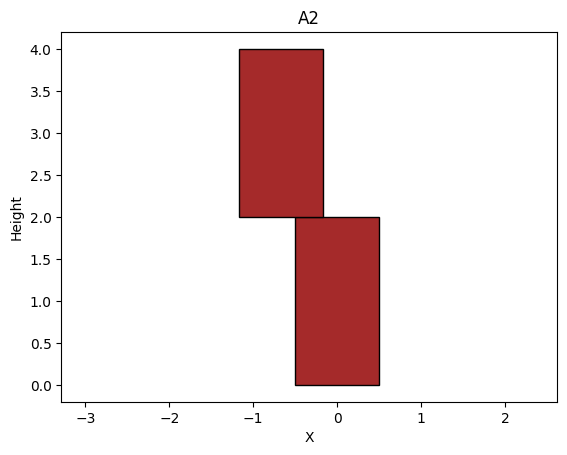

offset, thickness, direction
0.3, 1.0, 1.0
offset, thickness, direction
0.4, 1.0, -1.0
offset, thickness, direction
0.7, 1.0, -1.0
offset, thickness, direction
0.2, 1.0, -1.0
offset, thickness, direction
0.7, 1.0, -1.0
offset, thickness, direction
0.2, 1.0, 1.0
offset, thickness, direction
0.0, 1.0, 1.0


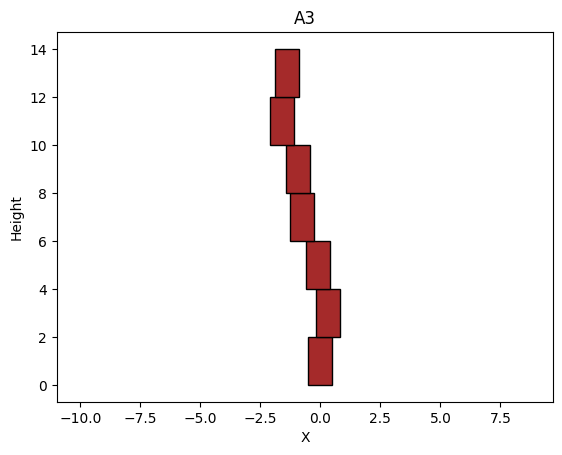

offset, thickness, direction
0.2, 1.0, -1.0
offset, thickness, direction
0.3, 1.0, -1.0
offset, thickness, direction
0.6, 1.0, -1.0
offset, thickness, direction
0.4, 1.0, -1.0
offset, thickness, direction
0.6, 1.0, -1.0
offset, thickness, direction
0.7, 1.0, -1.0
offset, thickness, direction
0.2, 1.0, 1.0
offset, thickness, direction
0.0, 1.0, 1.0
offset, thickness, direction
0.0, 1.0, 1.0
offset, thickness, direction
0.2, 1.0, 1.0
offset, thickness, direction
0.5, 1.0, 1.0


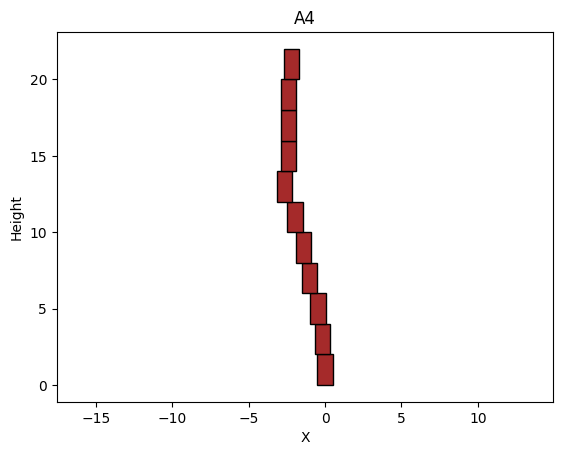

offset, thickness, direction
0.0, 1.0, 1.0
offset, thickness, direction
0.2, 1.0, -1.0
offset, thickness, direction
0.6, 1.0, -1.0
offset, thickness, direction
0.3, 1.0, -1.0
offset, thickness, direction
0.4, 1.0, -1.0
offset, thickness, direction
0.6, 1.0, -1.0
offset, thickness, direction
0.7, 1.0, -1.0
offset, thickness, direction
0.1, 1.0, 1.0
offset, thickness, direction
0.0, 1.0, 1.0
offset, thickness, direction
0.1, 1.0, 1.0
offset, thickness, direction
0.5, 1.0, -1.0
offset, thickness, direction
0.5, 1.0, -1.0
offset, thickness, direction
0.2, 1.0, 1.0
offset, thickness, direction
0.1, 1.0, 1.0
offset, thickness, direction
0.3, 1.0, 1.0


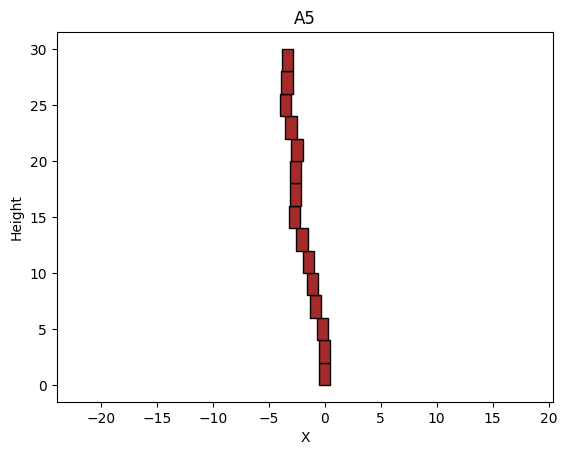

offset, thickness, direction
0.1, 1.0, 1.0
offset, thickness, direction
0.0, 1.0, 1.0
offset, thickness, direction
0.7, 1.0, -1.0
offset, thickness, direction
0.3, 1.0, -1.0
offset, thickness, direction
0.4, 1.0, -1.0
offset, thickness, direction
0.7, 1.0, -1.0
offset, thickness, direction
0.2, 1.0, -1.0
offset, thickness, direction
0.2, 1.0, 1.0
offset, thickness, direction
0.0, 1.0, 1.0
offset, thickness, direction
0.2, 1.0, -1.0
offset, thickness, direction
0.1, 1.0, 1.0


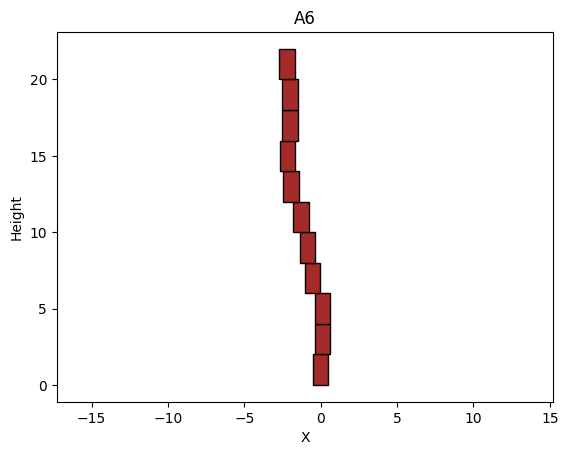

offset, thickness, direction
0.1, 1.0, 1.0
offset, thickness, direction
0.3, 1.0, -1.0
offset, thickness, direction
0.1, 1.0, 1.0
offset, thickness, direction
0.0, 1.0, -1.0
offset, thickness, direction
0.2, 1.0, -1.0
offset, thickness, direction
0.3, 1.0, -1.0
offset, thickness, direction
0.5, 1.0, -1.0
offset, thickness, direction
0.0, 1.0, 1.0
offset, thickness, direction
0.2, 1.0, -1.0
offset, thickness, direction
0.2, 1.0, 1.0
offset, thickness, direction
0.2, 1.0, 1.0
offset, thickness, direction
0.2, 1.0, -1.0
offset, thickness, direction
0.3, 1.0, 1.0
offset, thickness, direction
0.7, 1.0, -1.0
offset, thickness, direction
0.5, 1.0, -1.0


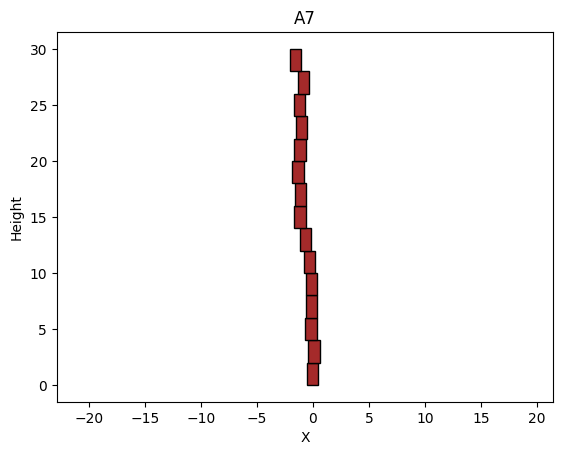

offset, thickness, direction
0.1, 1.0, -1.0
offset, thickness, direction
0.1, 1.0, -1.0
offset, thickness, direction
0.1, 1.0, 1.0
offset, thickness, direction
0.0, 1.0, -1.0
offset, thickness, direction
0.2, 1.0, -1.0
offset, thickness, direction
0.1, 1.0, 1.0
offset, thickness, direction
0.1, 1.0, 1.0
offset, thickness, direction
0.2, 1.0, 1.0
offset, thickness, direction
0.1, 1.0, 1.0
offset, thickness, direction
0.7, 1.0, -1.0
offset, thickness, direction
0.4, 1.0, -1.0
offset, thickness, direction
0.2, 1.0, -1.0
offset, thickness, direction
0.5, 1.0, -1.0
offset, thickness, direction
0.2, 1.0, 1.0
offset, thickness, direction
0.0, 1.0, 1.0


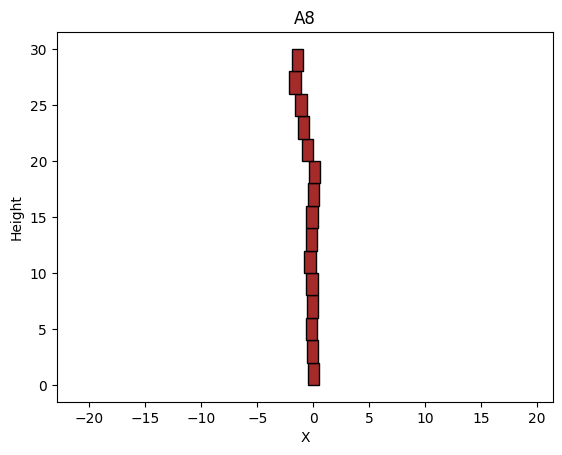

offset, thickness, direction
0.5, 1.0, -1.0
offset, thickness, direction
0.5, 1.0, 1.0
offset, thickness, direction
0.4, 1.0, -1.0
offset, thickness, direction
0.3, 1.0, 1.0
offset, thickness, direction
0.7, 1.0, -1.0
offset, thickness, direction
0.0, 1.0, 1.0
offset, thickness, direction
0.5, 1.0, -1.0


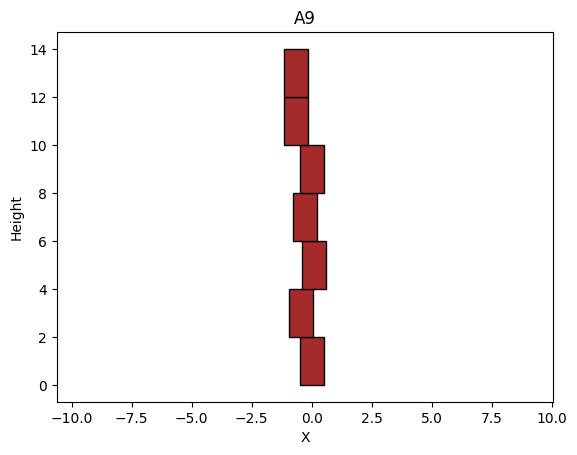

offset, thickness, direction
0.4, 1.0, -1.0
offset, thickness, direction
0.7, 1.0, -1.0
offset, thickness, direction
0.3, 1.0, 1.0
offset, thickness, direction
0.0, 1.0, 1.0


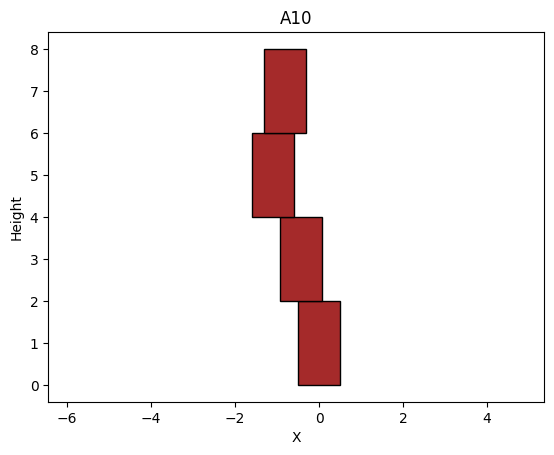

offset, thickness, direction
0.2, 1.0, 1.0
offset, thickness, direction
0.6, 1.0, -1.0
offset, thickness, direction
0.2, 1.0, 1.0
offset, thickness, direction
0.3, 1.0, 1.0
offset, thickness, direction
0.5, 1.0, -1.0
offset, thickness, direction
0.4, 1.0, 1.0
offset, thickness, direction
0.6, 1.0, -1.0
offset, thickness, direction
0.7, 1.0, -1.0
offset, thickness, direction
0.4, 1.0, 1.0
offset, thickness, direction
0.6, 1.0, -1.0
offset, thickness, direction
0.3, 1.0, 1.0
offset, thickness, direction
0.6, 1.0, -1.0
offset, thickness, direction
0.0, 1.0, 1.0
offset, thickness, direction
0.6, 1.0, -1.0
offset, thickness, direction
0.4, 1.0, -1.0


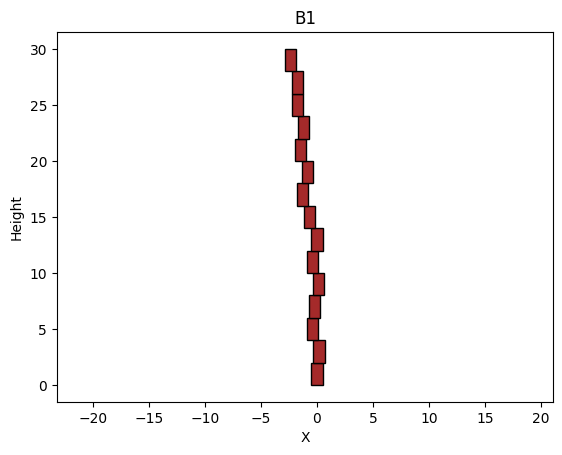

offset, thickness, direction
0.2, 1.0, -1.0
offset, thickness, direction
0.4, 1.0, -1.0
offset, thickness, direction
0.4, 1.0, -1.0
offset, thickness, direction
0.7, 1.0, -1.0
offset, thickness, direction
0.1, 1.0, 1.0
offset, thickness, direction
0.0, 1.0, 1.0
offset, thickness, direction
0.4, 1.0, 1.0
offset, thickness, direction
0.1, 1.0, 1.0


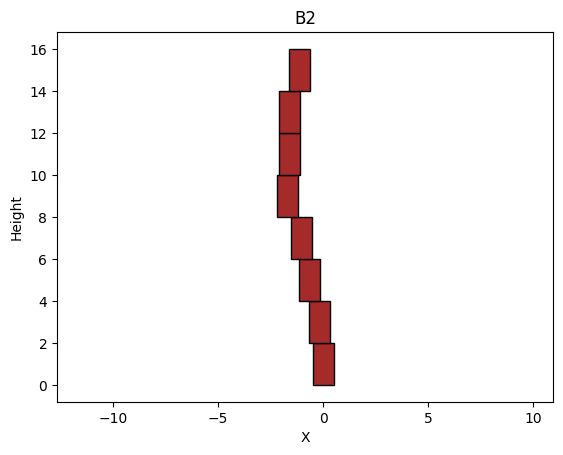

offset, thickness, direction
0.3, 1.0, -1.0
offset, thickness, direction
0.3, 1.0, -1.0
offset, thickness, direction
0.7, 1.0, -1.0
offset, thickness, direction
0.6, 1.0, -1.0
offset, thickness, direction
0.4, 1.0, 1.0
offset, thickness, direction
0.4, 1.0, -1.0
offset, thickness, direction
0.1, 1.0, 1.0
offset, thickness, direction
0.1, 1.0, -1.0
offset, thickness, direction
0.0, 1.0, 1.0
offset, thickness, direction
0.5, 1.0, 1.0
offset, thickness, direction
0.5, 1.0, -1.0


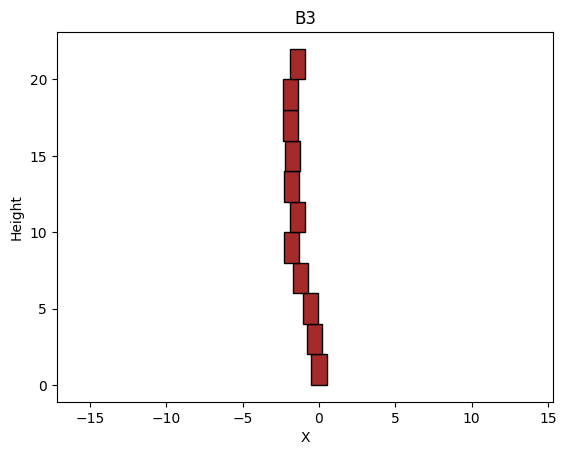

offset, thickness, direction
0.3, 1.0, -1.0
offset, thickness, direction
0.4, 1.0, -1.0
offset, thickness, direction
0.7, 1.0, -1.0
offset, thickness, direction
0.4, 1.0, 1.0
offset, thickness, direction
0.5, 1.0, 1.0
offset, thickness, direction
0.0, 1.0, 1.0


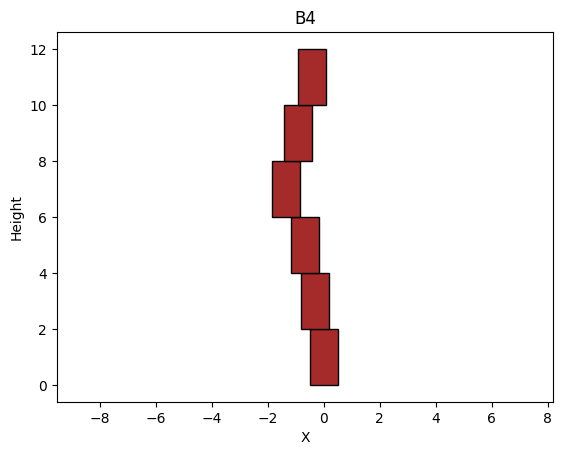

offset, thickness, direction
0.4, 1.0, -1.0
offset, thickness, direction
0.7, 1.0, -1.0
offset, thickness, direction
0.5, 1.0, 1.0
offset, thickness, direction
0.0, 1.0, 1.0


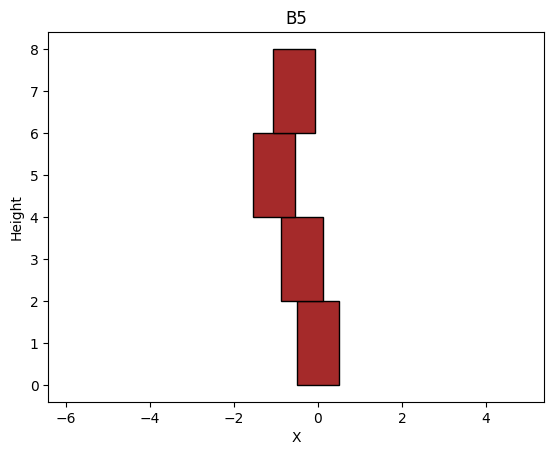

offset, thickness, direction
0.4, 1.0, -1.0
offset, thickness, direction
0.6, 1.0, -1.0
offset, thickness, direction
0.3, 1.0, 1.0
offset, thickness, direction
0.5, 1.0, -1.0
offset, thickness, direction
0.3, 1.0, 1.0
offset, thickness, direction
0.4, 1.0, -1.0
offset, thickness, direction
0.7, 1.0, -1.0
offset, thickness, direction
0.1, 1.0, 1.0
offset, thickness, direction
0.0, 1.0, 1.0


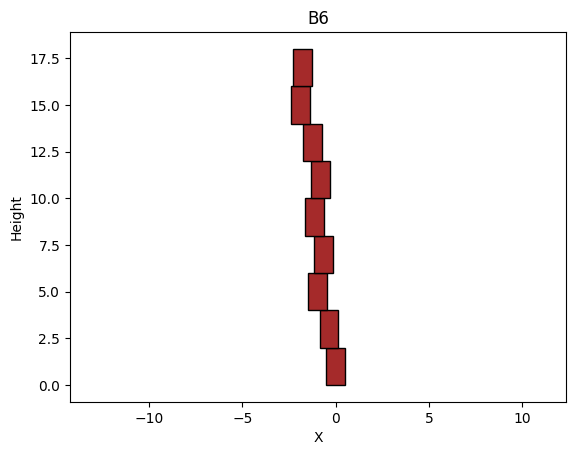

offset, thickness, direction
0.5, 1.0, -1.0
offset, thickness, direction
0.2, 1.0, 1.0
offset, thickness, direction
0.2, 1.0, 1.0
offset, thickness, direction
0.3, 1.0, 1.0
offset, thickness, direction
0.4, 1.0, -1.0
offset, thickness, direction
0.5, 1.0, -1.0
offset, thickness, direction
0.4, 1.0, -1.0
offset, thickness, direction
0.2, 1.0, 1.0
offset, thickness, direction
0.7, 1.0, -1.0
offset, thickness, direction
0.0, 1.0, 1.0


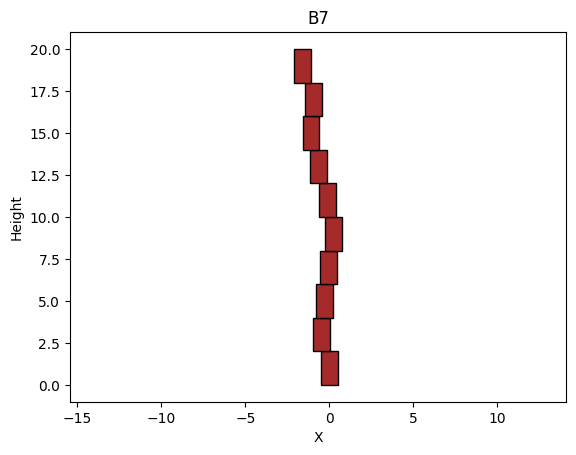

offset, thickness, direction
0.0, 1.0, 1.0
offset, thickness, direction
0.3, 1.0, -1.0
offset, thickness, direction
0.4, 1.0, -1.0
offset, thickness, direction
0.1, 1.0, 1.0
offset, thickness, direction
0.2, 1.0, -1.0
offset, thickness, direction
0.7, 1.0, -1.0
offset, thickness, direction
0.2, 1.0, -1.0
offset, thickness, direction
0.2, 1.0, -1.0
offset, thickness, direction
0.3, 1.0, 1.0
offset, thickness, direction
0.2, 1.0, 1.0
offset, thickness, direction
0.1, 1.0, 1.0
offset, thickness, direction
0.2, 1.0, 1.0
offset, thickness, direction
0.6, 1.0, -1.0
offset, thickness, direction
0.0, 1.0, 1.0


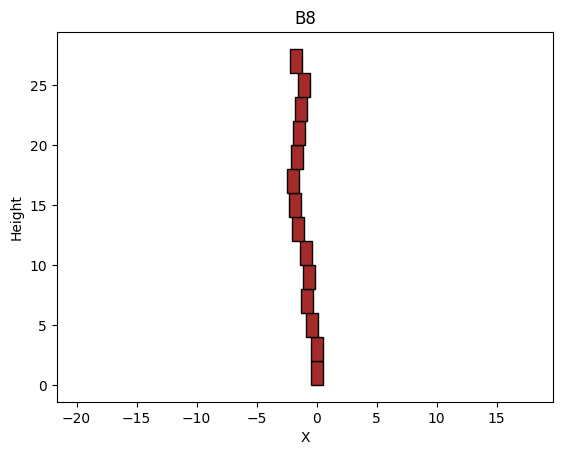

offset, thickness, direction
0.2, 1.0, 1.0
offset, thickness, direction
0.1, 1.0, -1.0
offset, thickness, direction
0.2, 1.0, -1.0
offset, thickness, direction
0.0, 1.0, -1.0
offset, thickness, direction
0.0, 1.0, 1.0
offset, thickness, direction
0.4, 1.0, -1.0
offset, thickness, direction
0.2, 1.0, 1.0
offset, thickness, direction
0.2, 1.0, 1.0
offset, thickness, direction
0.3, 1.0, 1.0
offset, thickness, direction
0.7, 1.0, -1.0


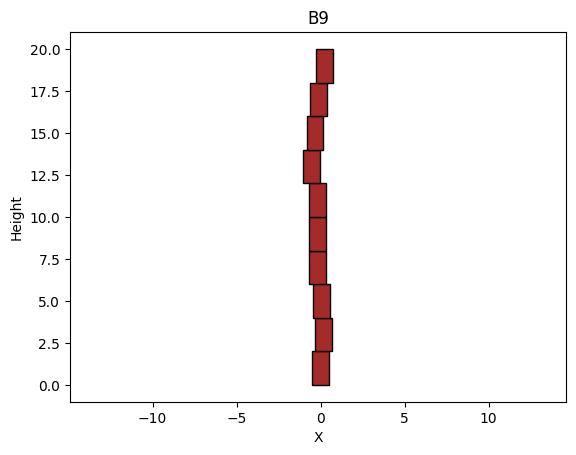

offset, thickness, direction
0.4, 1.0, -1.0
offset, thickness, direction
0.5, 1.0, -1.0
offset, thickness, direction
0.4, 1.0, -1.0
offset, thickness, direction
0.6, 1.0, -1.0
offset, thickness, direction
0.4, 1.0, -1.0
offset, thickness, direction
0.4, 1.0, 1.0
offset, thickness, direction
0.7, 1.0, -1.0
offset, thickness, direction
0.4, 1.0, -1.0
offset, thickness, direction
0.3, 1.0, 1.0
offset, thickness, direction
0.3, 1.0, 1.0
offset, thickness, direction
0.6, 1.0, -1.0
offset, thickness, direction
0.1, 1.0, 1.0
offset, thickness, direction
0.0, 1.0, 1.0
offset, thickness, direction
0.2, 1.0, 1.0
offset, thickness, direction
0.4, 1.0, 1.0


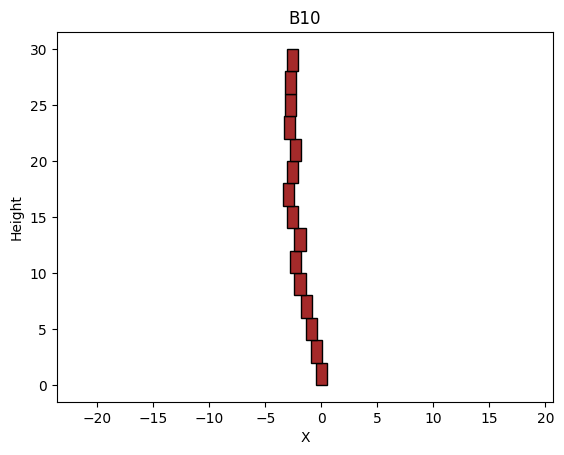

offset, thickness, direction
0.0, 1.0, 1.0
offset, thickness, direction
0.7, 1.0, -1.0


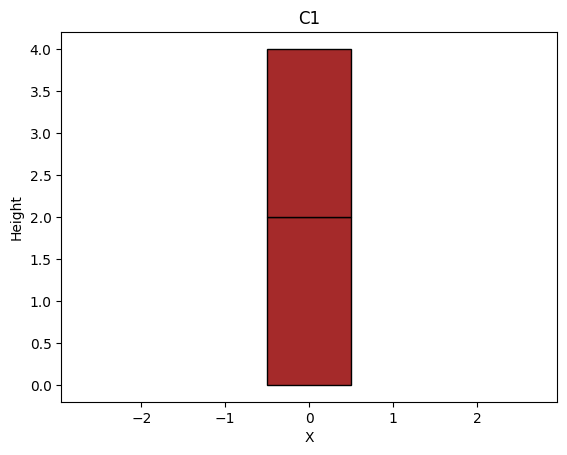

offset, thickness, direction
0.5, 1.0, -1.0
offset, thickness, direction
0.4, 1.0, 1.0
offset, thickness, direction
0.6, 1.0, -1.0
offset, thickness, direction
0.5, 1.0, 1.0
offset, thickness, direction
0.5, 1.0, -1.0
offset, thickness, direction
0.7, 1.0, -1.0
offset, thickness, direction
0.5, 1.0, 1.0
offset, thickness, direction
0.4, 1.0, -1.0
offset, thickness, direction
0.3, 1.0, -1.0
offset, thickness, direction
0.3, 1.0, -1.0
offset, thickness, direction
0.0, 1.0, 1.0
offset, thickness, direction
0.4, 1.0, 1.0
offset, thickness, direction
0.3, 1.0, 1.0
offset, thickness, direction
0.1, 1.0, 1.0


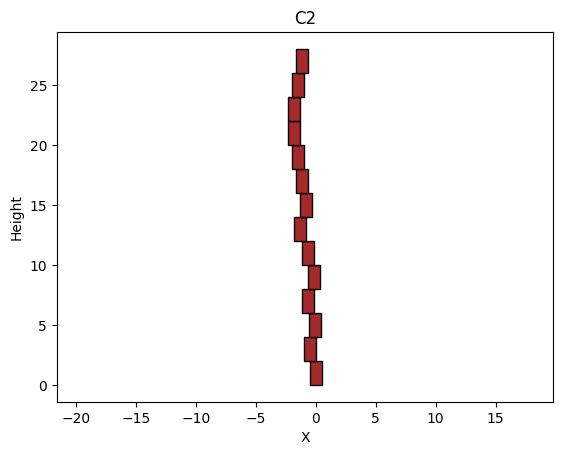

offset, thickness, direction
0.4, 1.0, -1.0
offset, thickness, direction
0.6, 1.0, 1.0
offset, thickness, direction
0.3, 1.0, 1.0
offset, thickness, direction
0.5, 1.0, -1.0
offset, thickness, direction
0.7, 1.0, -1.0
offset, thickness, direction
0.4, 1.0, 1.0
offset, thickness, direction
0.6, 1.0, -1.0
offset, thickness, direction
0.0, 1.0, 1.0


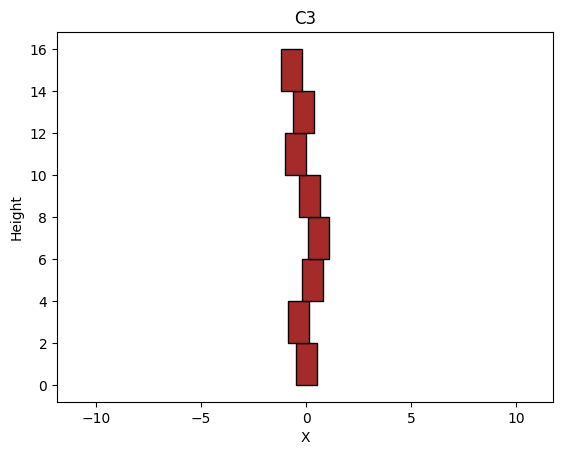

offset, thickness, direction
0.3, 1.0, -1.0
offset, thickness, direction
0.4, 1.0, -1.0
offset, thickness, direction
0.5, 1.0, 1.0
offset, thickness, direction
0.6, 1.0, -1.0
offset, thickness, direction
0.5, 1.0, -1.0
offset, thickness, direction
0.0, 1.0, 1.0
offset, thickness, direction
0.7, 1.0, 1.0


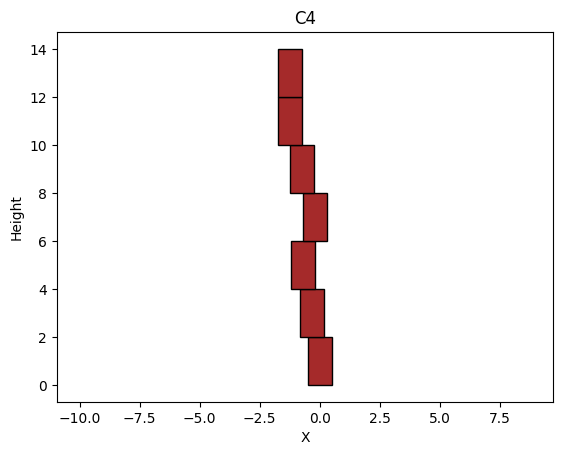

offset, thickness, direction
0.4, 1.0, 1.0
offset, thickness, direction
0.6, 1.0, -1.0
offset, thickness, direction
0.5, 1.0, 1.0
offset, thickness, direction
0.5, 1.0, -1.0
offset, thickness, direction
0.7, 1.0, -1.0
offset, thickness, direction
0.5, 1.0, -1.0
offset, thickness, direction
0.6, 1.0, -1.0
offset, thickness, direction
0.1, 1.0, -1.0
offset, thickness, direction
0.0, 1.0, 1.0


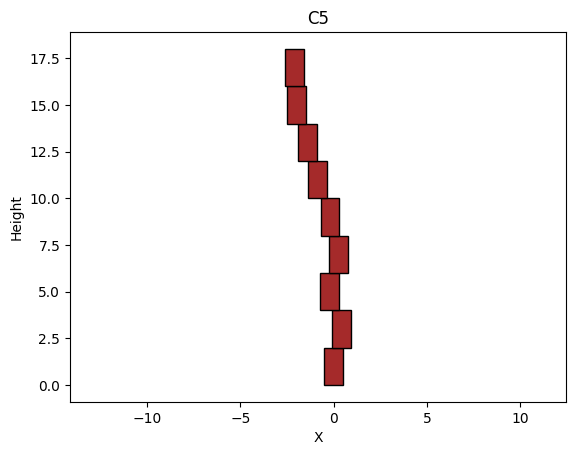

offset, thickness, direction
0.7, 1.0, -1.0
offset, thickness, direction
0.0, 1.0, 1.0


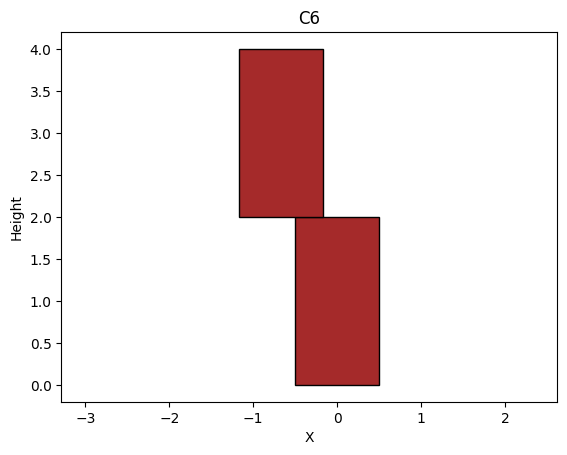

offset, thickness, direction
0.3, 1.0, 1.0
offset, thickness, direction
0.4, 1.0, -1.0
offset, thickness, direction
0.5, 1.0, -1.0
offset, thickness, direction
0.7, 1.0, -1.0
offset, thickness, direction
0.0, 1.0, 1.0


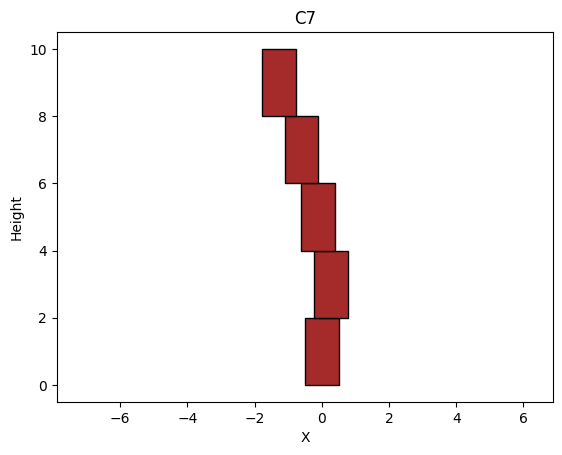

offset, thickness, direction
0.7, 1.0, -1.0
offset, thickness, direction
0.4, 1.0, -1.0
offset, thickness, direction
0.3, 1.0, 1.0
offset, thickness, direction
0.7, 1.0, -1.0
offset, thickness, direction
0.5, 1.0, -1.0
offset, thickness, direction
0.3, 1.0, -1.0
offset, thickness, direction
0.5, 1.0, -1.0
offset, thickness, direction
0.2, 1.0, 1.0
offset, thickness, direction
0.6, 1.0, -1.0
offset, thickness, direction
0.5, 1.0, 1.0
offset, thickness, direction
0.6, 1.0, 1.0
offset, thickness, direction
0.2, 1.0, 1.0
offset, thickness, direction
0.3, 1.0, 1.0
offset, thickness, direction
0.0, 1.0, 1.0


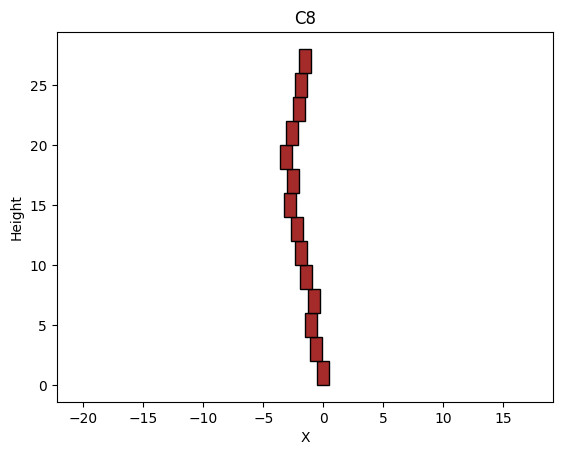

offset, thickness, direction
0.3, 1.0, -1.0
offset, thickness, direction
0.2, 1.0, -1.0
offset, thickness, direction
0.0, 1.0, -1.0
offset, thickness, direction
0.1, 1.0, 1.0
offset, thickness, direction
0.0, 1.0, 1.0
offset, thickness, direction
0.1, 1.0, 1.0
offset, thickness, direction
0.1, 1.0, 1.0
offset, thickness, direction
0.2, 1.0, -1.0
offset, thickness, direction
0.2, 1.0, -1.0
offset, thickness, direction
0.2, 1.0, -1.0
offset, thickness, direction
0.3, 1.0, -1.0
offset, thickness, direction
0.2, 1.0, 1.0
offset, thickness, direction
0.0, 1.0, 1.0
offset, thickness, direction
0.5, 1.0, 1.0
offset, thickness, direction
0.7, 1.0, -1.0


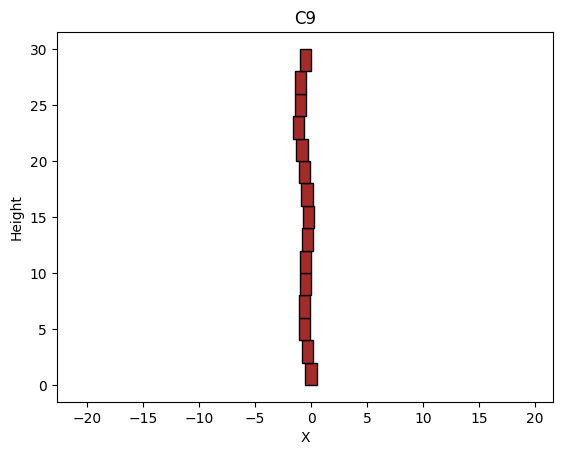

offset, thickness, direction
0.6, 1.0, -1.0
offset, thickness, direction
0.5, 1.0, -1.0
offset, thickness, direction
0.5, 1.0, 1.0
offset, thickness, direction
0.4, 1.0, -1.0
offset, thickness, direction
0.7, 1.0, -1.0
offset, thickness, direction
0.6, 1.0, -1.0
offset, thickness, direction
0.5, 1.0, 1.0
offset, thickness, direction
0.5, 1.0, -1.0
offset, thickness, direction
0.4, 1.0, -1.0
offset, thickness, direction
0.4, 1.0, 1.0
offset, thickness, direction
0.3, 1.0, 1.0
offset, thickness, direction
0.2, 1.0, 1.0
offset, thickness, direction
0.3, 1.0, -1.0
offset, thickness, direction
0.0, 1.0, 1.0
offset, thickness, direction
0.1, 1.0, 1.0


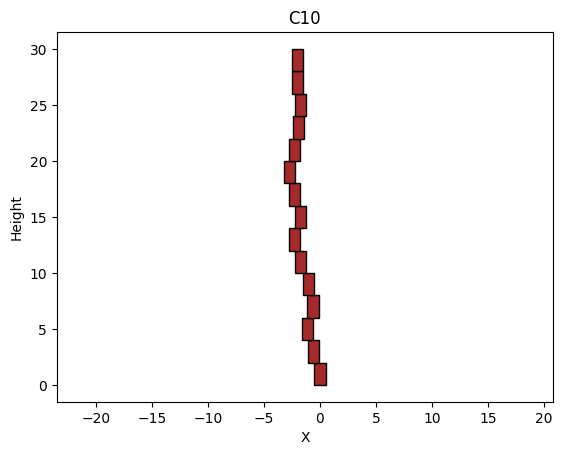

offset, thickness, direction
0.0, 1.0, 1.0
offset, thickness, direction
0.7, 1.0, -1.0


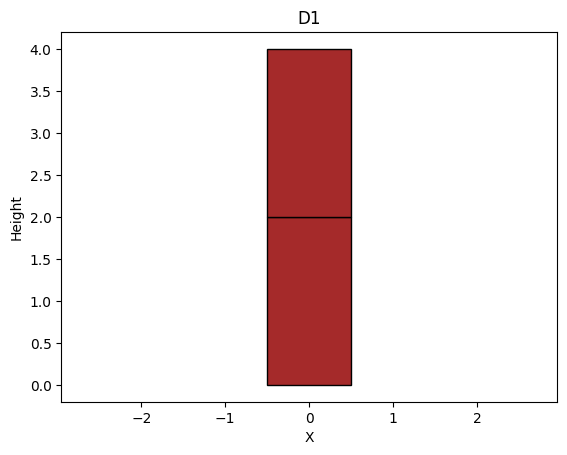

offset, thickness, direction
0.6, 1.0, -1.0
offset, thickness, direction
0.5, 1.0, 1.0
offset, thickness, direction
0.4, 1.0, 1.0
offset, thickness, direction
0.5, 1.0, -1.0
offset, thickness, direction
0.6, 1.0, -1.0
offset, thickness, direction
0.4, 1.0, -1.0
offset, thickness, direction
0.5, 1.0, -1.0
offset, thickness, direction
0.7, 1.0, -1.0
offset, thickness, direction
0.1, 1.0, 1.0
offset, thickness, direction
0.3, 1.0, 1.0
offset, thickness, direction
0.0, 1.0, 1.0


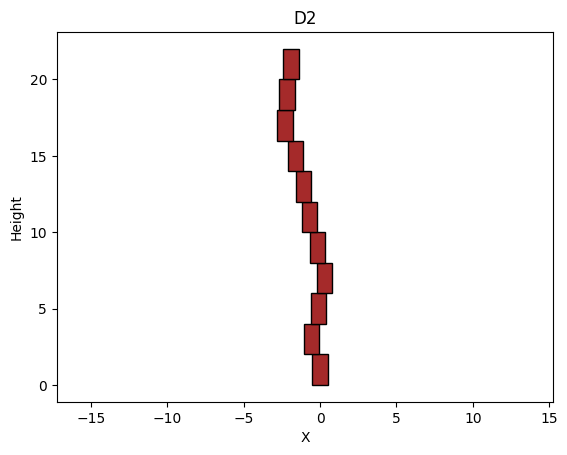

offset, thickness, direction
0.3, 1.0, -1.0
offset, thickness, direction
0.5, 1.0, -1.0
offset, thickness, direction
0.6, 1.0, 1.0
offset, thickness, direction
0.4, 1.0, -1.0
offset, thickness, direction
0.4, 1.0, 1.0
offset, thickness, direction
0.5, 1.0, 1.0
offset, thickness, direction
0.1, 1.0, -1.0
offset, thickness, direction
0.7, 1.0, -1.0
offset, thickness, direction
0.0, 1.0, 1.0


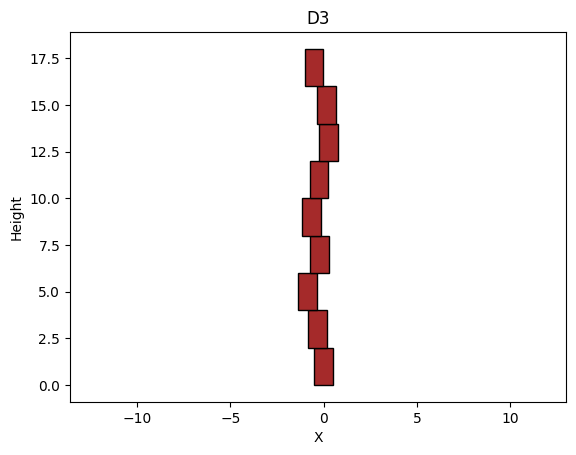

offset, thickness, direction
0.4, 1.0, 1.0
offset, thickness, direction
0.5, 1.0, -1.0
offset, thickness, direction
0.3, 1.0, -1.0
offset, thickness, direction
0.5, 1.0, 1.0
offset, thickness, direction
0.6, 1.0, 1.0
offset, thickness, direction
0.4, 1.0, 1.0
offset, thickness, direction
0.7, 1.0, -1.0
offset, thickness, direction
0.4, 1.0, -1.0
offset, thickness, direction
0.0, 1.0, 1.0
offset, thickness, direction
0.4, 1.0, -1.0


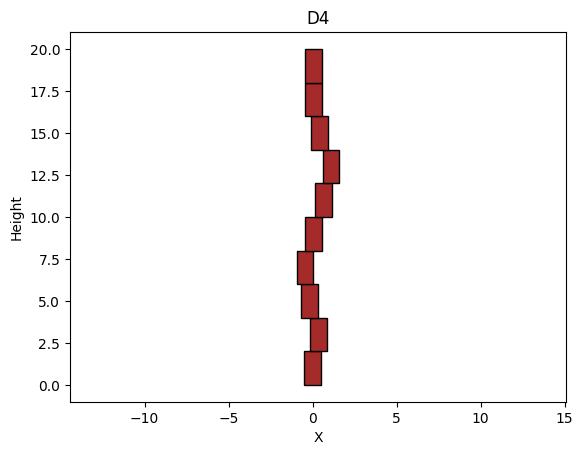

offset, thickness, direction
0.4, 1.0, -1.0
offset, thickness, direction
0.6, 1.0, -1.0
offset, thickness, direction
0.4, 1.0, 1.0
offset, thickness, direction
0.4, 1.0, -1.0
offset, thickness, direction
0.5, 1.0, -1.0
offset, thickness, direction
0.3, 1.0, -1.0
offset, thickness, direction
0.5, 1.0, 1.0
offset, thickness, direction
0.4, 1.0, 1.0
offset, thickness, direction
0.6, 1.0, 1.0
offset, thickness, direction
0.5, 1.0, 1.0
offset, thickness, direction
0.7, 1.0, -1.0
offset, thickness, direction
0.5, 1.0, -1.0
offset, thickness, direction
0.1, 1.0, 1.0
offset, thickness, direction
0.0, 1.0, 1.0


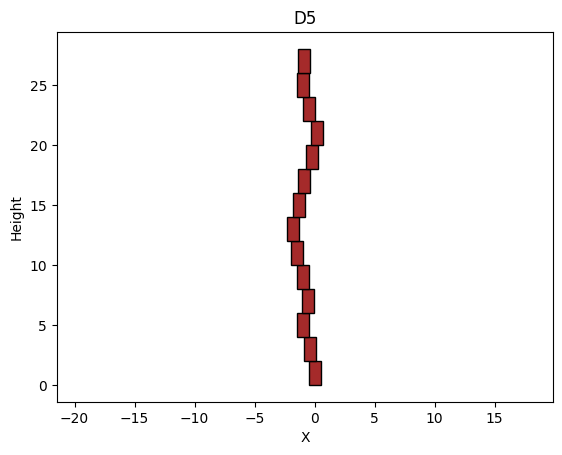

offset, thickness, direction
0.7, 1.0, -1.0
offset, thickness, direction
0.0, 1.0, 1.0


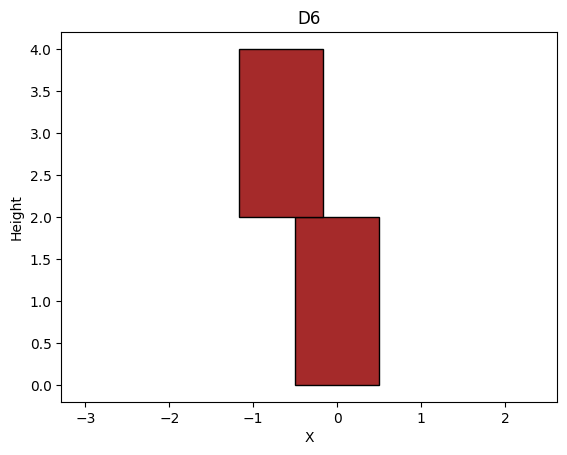

offset, thickness, direction
0.5, 1.0, -1.0
offset, thickness, direction
0.4, 1.0, 1.0
offset, thickness, direction
0.5, 1.0, -1.0
offset, thickness, direction
0.4, 1.0, 1.0
offset, thickness, direction
0.4, 1.0, -1.0
offset, thickness, direction
0.3, 1.0, 1.0
offset, thickness, direction
0.4, 1.0, -1.0
offset, thickness, direction
0.5, 1.0, -1.0
offset, thickness, direction
0.2, 1.0, 1.0
offset, thickness, direction
0.7, 1.0, -1.0
offset, thickness, direction
0.3, 1.0, -1.0
offset, thickness, direction
0.0, 1.0, 1.0


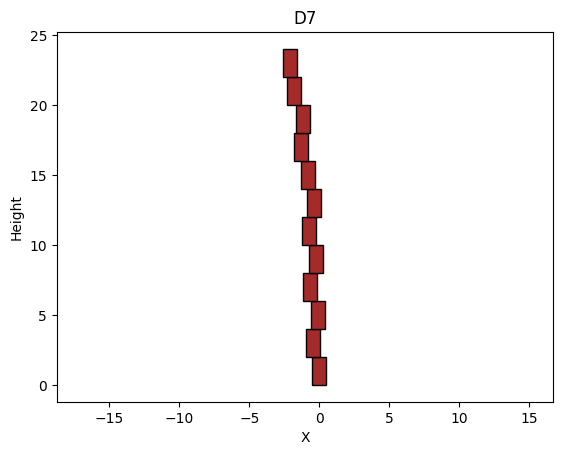

offset, thickness, direction
0.4, 1.0, -1.0
offset, thickness, direction
0.7, 1.0, -1.0
offset, thickness, direction
0.4, 1.0, -1.0
offset, thickness, direction
0.3, 1.0, -1.0
offset, thickness, direction
0.3, 1.0, 1.0
offset, thickness, direction
0.5, 1.0, -1.0
offset, thickness, direction
0.6, 1.0, -1.0
offset, thickness, direction
0.4, 1.0, 1.0
offset, thickness, direction
0.5, 1.0, 1.0
offset, thickness, direction
0.6, 1.0, 1.0
offset, thickness, direction
0.3, 1.0, 1.0
offset, thickness, direction
0.2, 1.0, 1.0
offset, thickness, direction
0.7, 1.0, -1.0
offset, thickness, direction
0.0, 1.0, 1.0


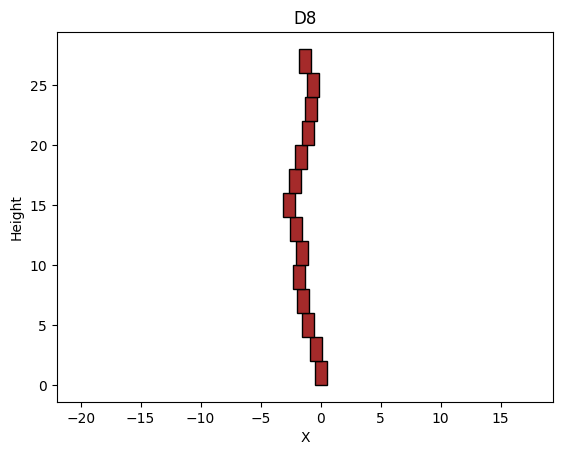

offset, thickness, direction
0.7, 1.0, -1.0
offset, thickness, direction
0.5, 1.0, -1.0
offset, thickness, direction
0.1, 1.0, -1.0
offset, thickness, direction
0.5, 1.0, 1.0
offset, thickness, direction
0.5, 1.0, -1.0
offset, thickness, direction
0.3, 1.0, -1.0
offset, thickness, direction
0.6, 1.0, -1.0
offset, thickness, direction
0.4, 1.0, -1.0
offset, thickness, direction
0.0, 1.0, 1.0
offset, thickness, direction
0.3, 1.0, 1.0
offset, thickness, direction
0.1, 1.0, 1.0
offset, thickness, direction
0.3, 1.0, 1.0
offset, thickness, direction
0.3, 1.0, 1.0
offset, thickness, direction
0.0, 1.0, 1.0


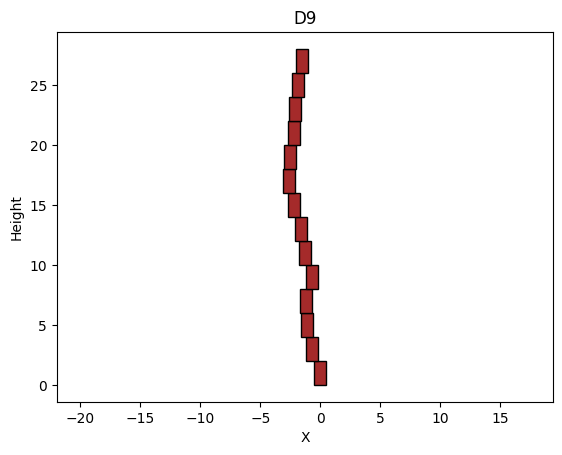

offset, thickness, direction
0.0, 1.0, 1.0
offset, thickness, direction
0.7, 1.0, -1.0


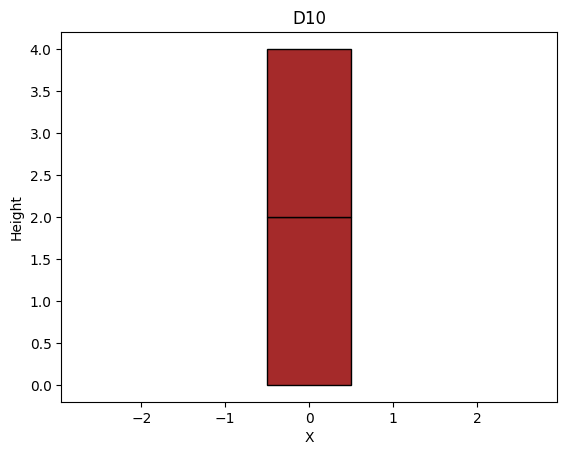

offset, thickness, direction
0.0, 1.0, 1.0
offset, thickness, direction
0.7, 1.0, -1.0


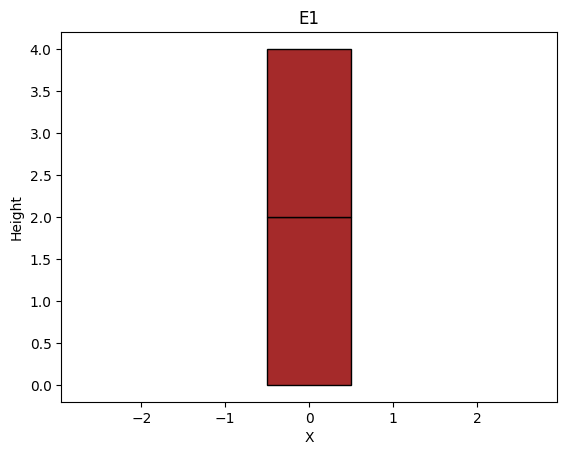

offset, thickness, direction
0.6, 1.0, -1.0
offset, thickness, direction
0.6, 1.0, -1.0
offset, thickness, direction
0.6, 1.0, -1.0
offset, thickness, direction
0.5, 1.0, 1.0
offset, thickness, direction
0.5, 1.0, 1.0
offset, thickness, direction
0.5, 1.0, -1.0
offset, thickness, direction
0.5, 1.0, -1.0
offset, thickness, direction
0.4, 1.0, -1.0
offset, thickness, direction
0.6, 1.0, 1.0
offset, thickness, direction
0.4, 1.0, 1.0
offset, thickness, direction
0.5, 1.0, -1.0
offset, thickness, direction
0.1, 1.0, 1.0
offset, thickness, direction
0.3, 1.0, -1.0
offset, thickness, direction
0.0, 1.0, 1.0
offset, thickness, direction
0.7, 1.0, -1.0


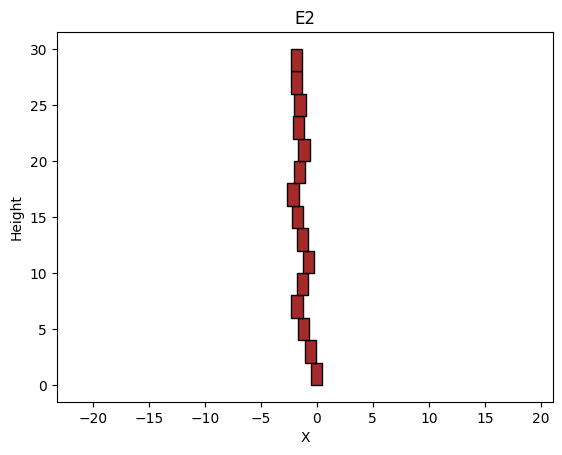

offset, thickness, direction
0.7, 1.0, -1.0
offset, thickness, direction
0.6, 1.0, -1.0
offset, thickness, direction
0.4, 1.0, 1.0
offset, thickness, direction
0.5, 1.0, 1.0
offset, thickness, direction
0.5, 1.0, -1.0
offset, thickness, direction
0.5, 1.0, 1.0
offset, thickness, direction
0.6, 1.0, -1.0
offset, thickness, direction
0.5, 1.0, -1.0
offset, thickness, direction
0.2, 1.0, 1.0
offset, thickness, direction
0.6, 1.0, -1.0
offset, thickness, direction
0.0, 1.0, 1.0


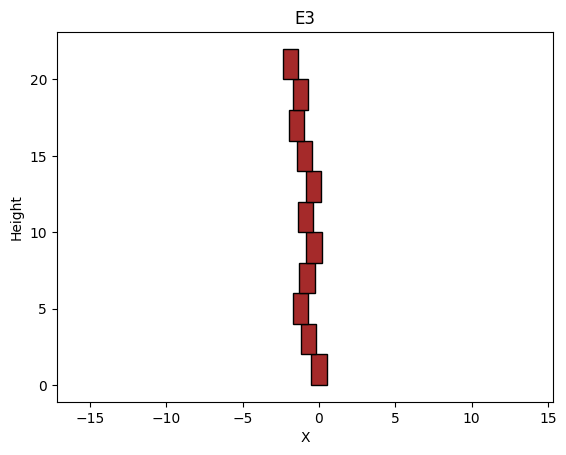

offset, thickness, direction
0.5, 1.0, -1.0
offset, thickness, direction
0.4, 1.0, 1.0
offset, thickness, direction
0.5, 1.0, -1.0
offset, thickness, direction
0.6, 1.0, -1.0
offset, thickness, direction
0.7, 1.0, -1.0
offset, thickness, direction
0.2, 1.0, 1.0
offset, thickness, direction
0.0, 1.0, 1.0


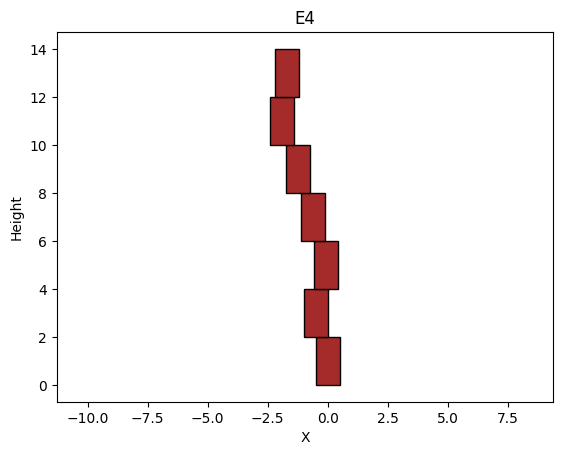

offset, thickness, direction
0.4, 1.0, -1.0
offset, thickness, direction
0.0, 1.0, 1.0
offset, thickness, direction
0.7, 1.0, -1.0


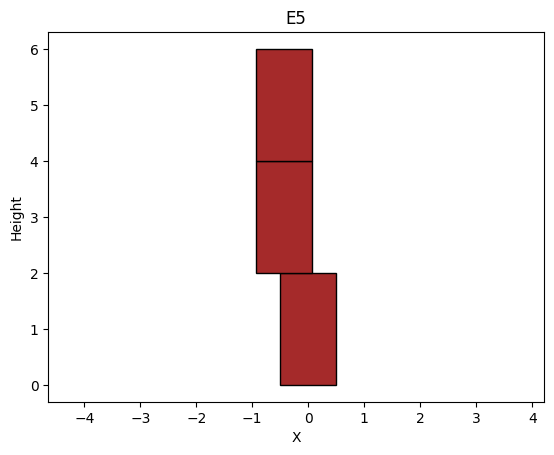

offset, thickness, direction
0.7, 1.0, -1.0
offset, thickness, direction
0.0, 1.0, 1.0


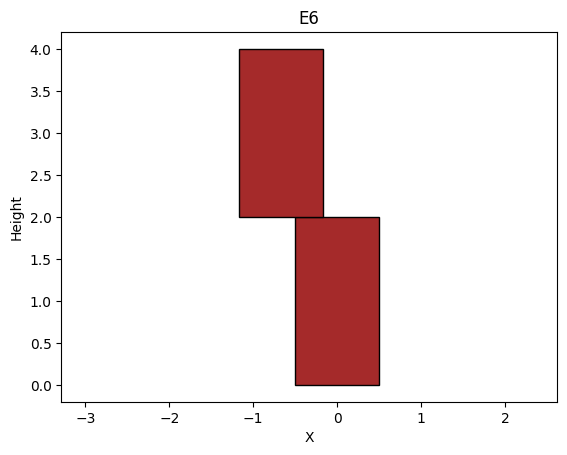

offset, thickness, direction
0.5, 1.0, 1.0
offset, thickness, direction
0.4, 1.0, -1.0
offset, thickness, direction
0.5, 1.0, -1.0
offset, thickness, direction
0.3, 1.0, -1.0
offset, thickness, direction
0.6, 1.0, -1.0
offset, thickness, direction
0.4, 1.0, -1.0
offset, thickness, direction
0.3, 1.0, 1.0
offset, thickness, direction
0.4, 1.0, 1.0
offset, thickness, direction
0.3, 1.0, 1.0
offset, thickness, direction
0.7, 1.0, -1.0
offset, thickness, direction
0.0, 1.0, 1.0
offset, thickness, direction
0.1, 1.0, 1.0


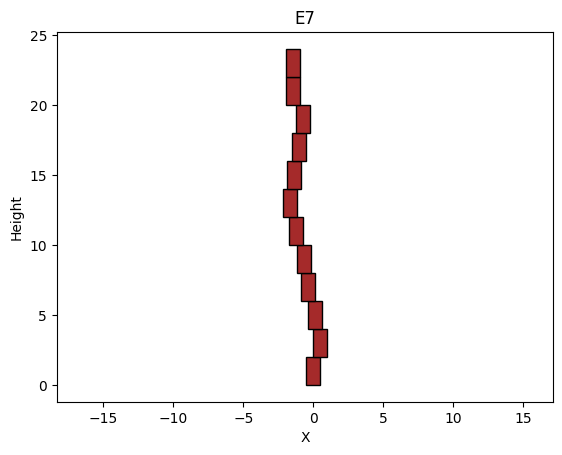

offset, thickness, direction
0.6, 1.0, -1.0
offset, thickness, direction
0.4, 1.0, -1.0
offset, thickness, direction
0.5, 1.0, -1.0
offset, thickness, direction
0.4, 1.0, -1.0
offset, thickness, direction
0.4, 1.0, 1.0
offset, thickness, direction
0.7, 1.0, -1.0
offset, thickness, direction
0.1, 1.0, 1.0
offset, thickness, direction
0.3, 1.0, 1.0
offset, thickness, direction
0.4, 1.0, 1.0
offset, thickness, direction
0.0, 1.0, 1.0


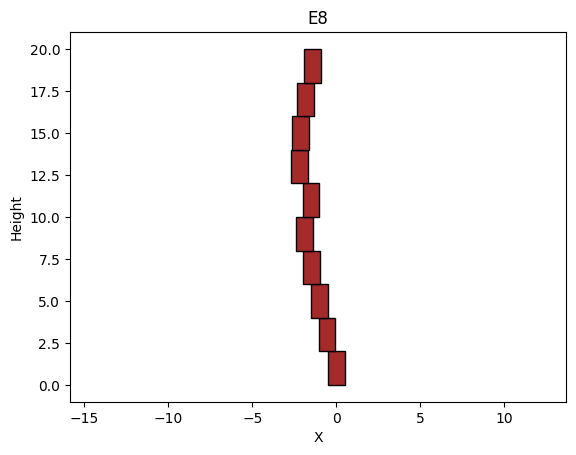

offset, thickness, direction
0.1, 1.0, -1.0
offset, thickness, direction
0.3, 1.0, 1.0
offset, thickness, direction
0.4, 1.0, -1.0
offset, thickness, direction
0.4, 1.0, -1.0
offset, thickness, direction
0.5, 1.0, -1.0
offset, thickness, direction
0.0, 1.0, 1.0
offset, thickness, direction
0.3, 1.0, 1.0
offset, thickness, direction
0.1, 1.0, -1.0
offset, thickness, direction
0.6, 1.0, -1.0
offset, thickness, direction
0.2, 1.0, 1.0
offset, thickness, direction
0.7, 1.0, -1.0
offset, thickness, direction
0.4, 1.0, 1.0
offset, thickness, direction
0.0, 1.0, 1.0
offset, thickness, direction
0.4, 1.0, 1.0


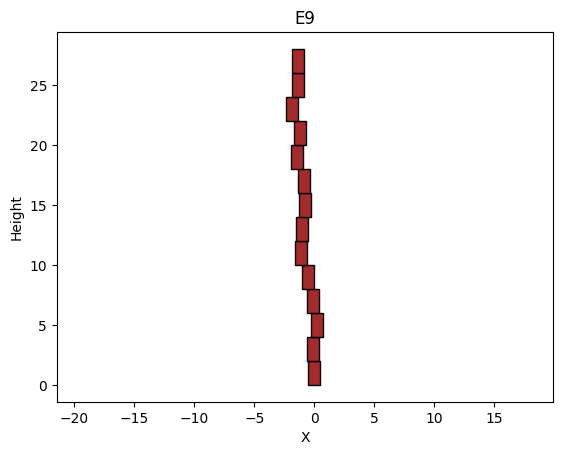

offset, thickness, direction
0.0, 1.0, 1.0
offset, thickness, direction
0.7, 1.0, -1.0


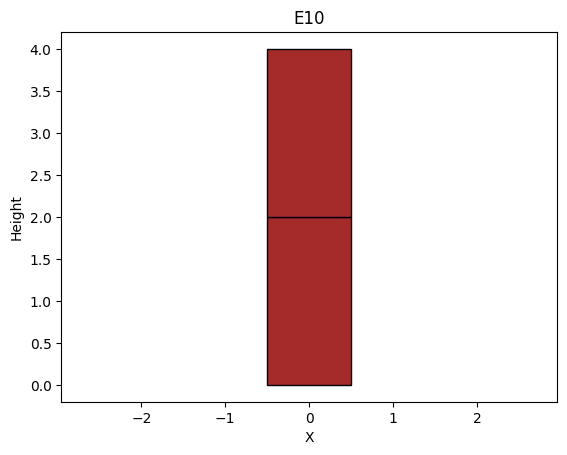

offset, thickness, direction
0.7, 1.0, -1.0
offset, thickness, direction
0.0, 1.0, 1.0


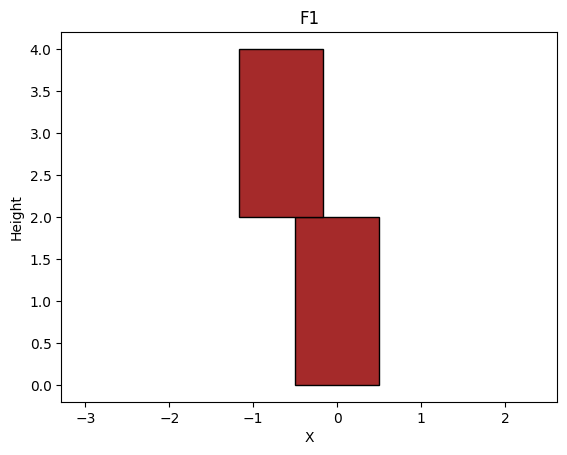

offset, thickness, direction
0.5, 1.0, -1.0
offset, thickness, direction
0.6, 1.0, -1.0
offset, thickness, direction
0.4, 1.0, -1.0
offset, thickness, direction
0.6, 1.0, 1.0
offset, thickness, direction
0.5, 1.0, -1.0
offset, thickness, direction
0.5, 1.0, -1.0
offset, thickness, direction
0.5, 1.0, 1.0
offset, thickness, direction
0.5, 1.0, 1.0
offset, thickness, direction
0.5, 1.0, 1.0
offset, thickness, direction
0.4, 1.0, -1.0
offset, thickness, direction
0.1, 1.0, 1.0
offset, thickness, direction
0.3, 1.0, -1.0
offset, thickness, direction
0.7, 1.0, -1.0
offset, thickness, direction
0.3, 1.0, 1.0
offset, thickness, direction
0.0, 1.0, 1.0


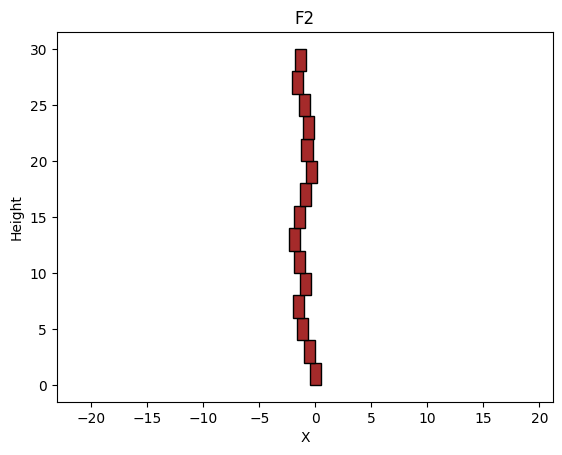

offset, thickness, direction
0.5, 1.0, -1.0
offset, thickness, direction
0.4, 1.0, 1.0
offset, thickness, direction
0.7, 1.0, -1.0
offset, thickness, direction
0.6, 1.0, -1.0
offset, thickness, direction
0.4, 1.0, 1.0
offset, thickness, direction
0.5, 1.0, -1.0
offset, thickness, direction
0.4, 1.0, -1.0
offset, thickness, direction
0.5, 1.0, 1.0
offset, thickness, direction
0.5, 1.0, -1.0
offset, thickness, direction
0.5, 1.0, -1.0
offset, thickness, direction
0.2, 1.0, 1.0
offset, thickness, direction
0.2, 1.0, 1.0
offset, thickness, direction
0.0, 1.0, 1.0


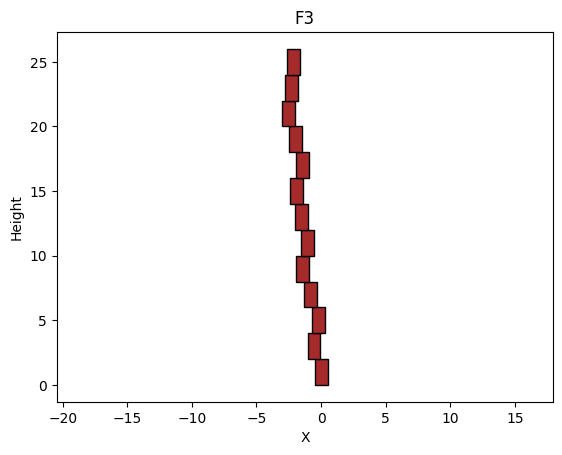

offset, thickness, direction
0.6, 1.0, -1.0
offset, thickness, direction
0.4, 1.0, 1.0
offset, thickness, direction
0.5, 1.0, 1.0
offset, thickness, direction
0.7, 1.0, -1.0
offset, thickness, direction
0.4, 1.0, 1.0
offset, thickness, direction
0.5, 1.0, -1.0
offset, thickness, direction
0.6, 1.0, -1.0
offset, thickness, direction
0.6, 1.0, -1.0
offset, thickness, direction
0.5, 1.0, 1.0
offset, thickness, direction
0.6, 1.0, -1.0
offset, thickness, direction
0.2, 1.0, 1.0
offset, thickness, direction
0.0, 1.0, 1.0


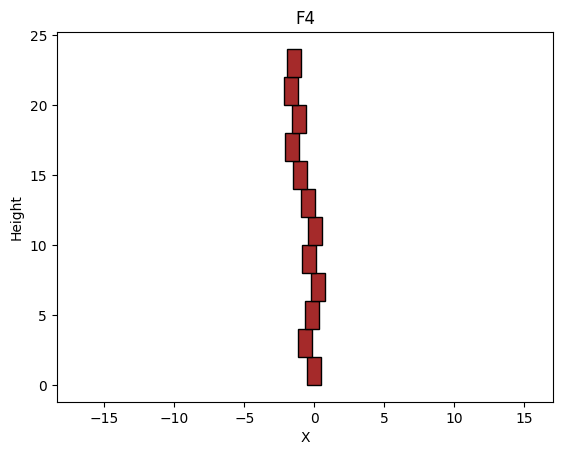

offset, thickness, direction
0.0, 1.0, 1.0
offset, thickness, direction
0.7, 1.0, -1.0


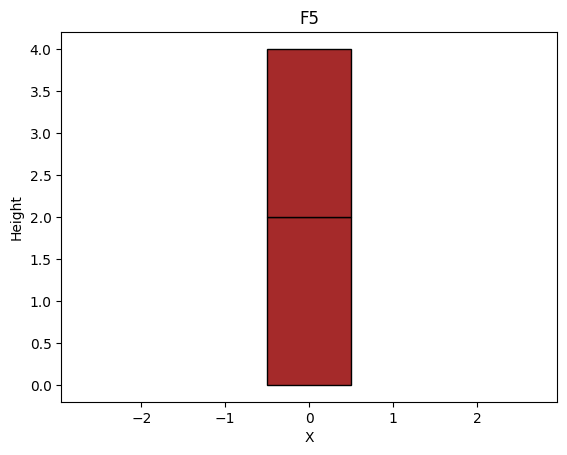

offset, thickness, direction
0.3, 1.0, 1.0
offset, thickness, direction
0.4, 1.0, -1.0
offset, thickness, direction
0.4, 1.0, 1.0
offset, thickness, direction
0.0, 1.0, -1.0
offset, thickness, direction
0.5, 1.0, -1.0
offset, thickness, direction
0.0, 1.0, -1.0
offset, thickness, direction
0.7, 1.0, 1.0
offset, thickness, direction
0.1, 1.0, -1.0
offset, thickness, direction
0.1, 1.0, 1.0


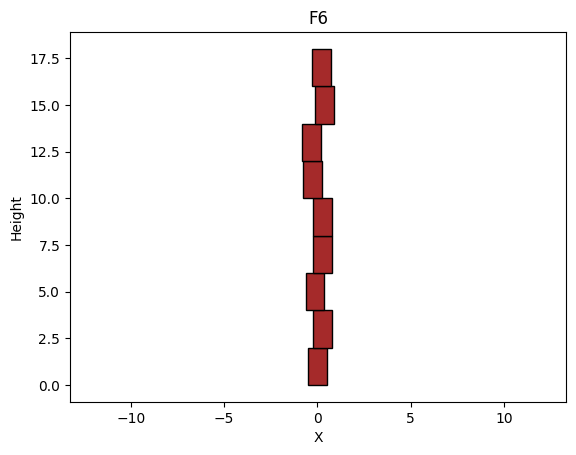

offset, thickness, direction
0.4, 1.0, 1.0
offset, thickness, direction
0.1, 1.0, -1.0
offset, thickness, direction
0.0, 1.0, 1.0
offset, thickness, direction
0.4, 1.0, -1.0
offset, thickness, direction
0.4, 1.0, -1.0
offset, thickness, direction
0.3, 1.0, 1.0
offset, thickness, direction
0.5, 1.0, -1.0
offset, thickness, direction
0.0, 1.0, 1.0
offset, thickness, direction
0.5, 1.0, -1.0
offset, thickness, direction
0.6, 1.0, -1.0
offset, thickness, direction
0.6, 1.0, 1.0
offset, thickness, direction
0.5, 1.0, 1.0
offset, thickness, direction
0.7, 1.0, -1.0
offset, thickness, direction
0.2, 1.0, 1.0


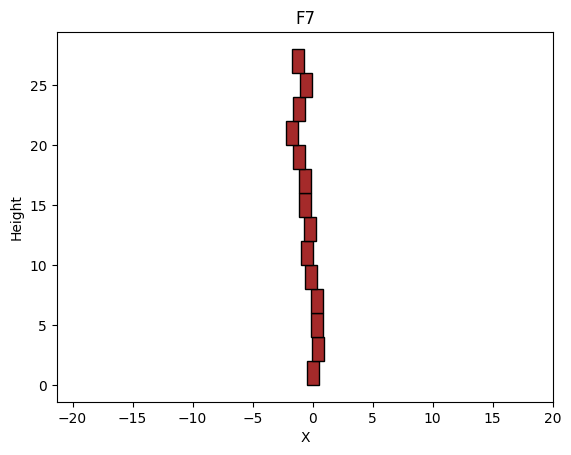

offset, thickness, direction
0.0, 1.0, 1.0
offset, thickness, direction
0.5, 1.0, 1.0
offset, thickness, direction
0.0, 1.0, -1.0
offset, thickness, direction
0.1, 1.0, -1.0
offset, thickness, direction
0.5, 1.0, -1.0
offset, thickness, direction
0.4, 1.0, 1.0
offset, thickness, direction
0.6, 1.0, -1.0
offset, thickness, direction
0.7, 1.0, -1.0
offset, thickness, direction
0.6, 1.0, 1.0
offset, thickness, direction
0.4, 1.0, 1.0


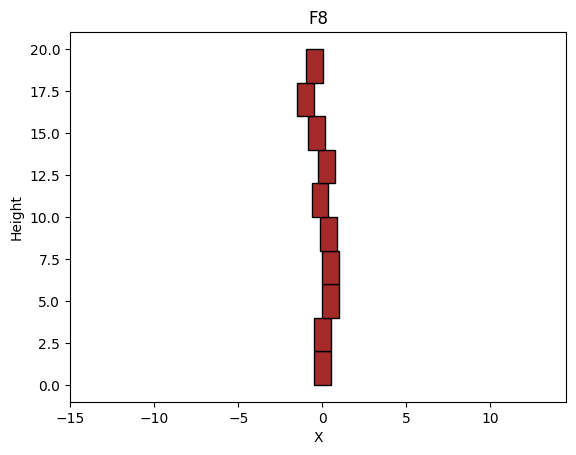

offset, thickness, direction
0.0, 1.0, 1.0
offset, thickness, direction
0.7, 1.0, -1.0


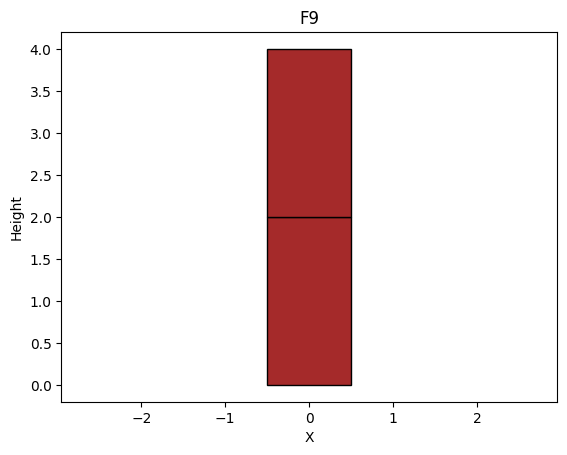

offset, thickness, direction
0.0, 1.0, 1.0
offset, thickness, direction
0.7, 1.0, -1.0


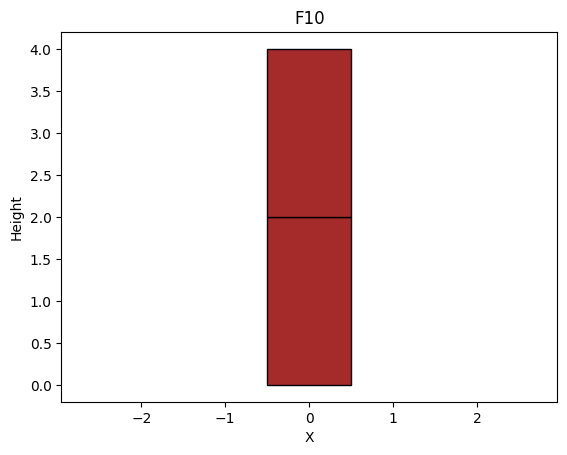

offset, thickness, direction
0.7, 1.0, -1.0
offset, thickness, direction
0.0, 1.0, 1.0


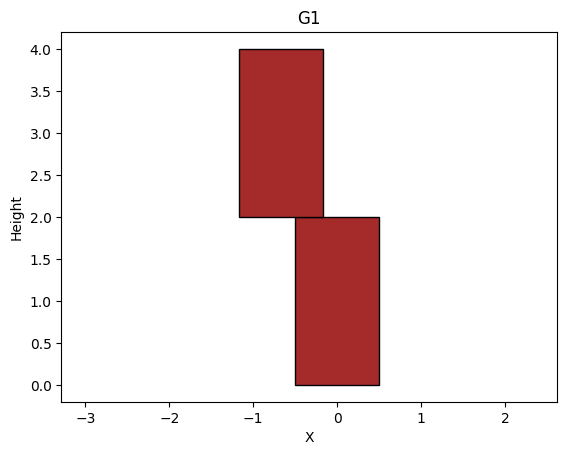

offset, thickness, direction
0.5, 1.0, -1.0
offset, thickness, direction
0.5, 1.0, -1.0
offset, thickness, direction
0.5, 1.0, 1.0
offset, thickness, direction
0.6, 1.0, -1.0
offset, thickness, direction
0.5, 1.0, 1.0
offset, thickness, direction
0.4, 1.0, -1.0
offset, thickness, direction
0.5, 1.0, 1.0
offset, thickness, direction
0.6, 1.0, -1.0
offset, thickness, direction
0.6, 1.0, 1.0
offset, thickness, direction
0.4, 1.0, -1.0
offset, thickness, direction
0.7, 1.0, -1.0
offset, thickness, direction
0.1, 1.0, 1.0
offset, thickness, direction
0.3, 1.0, 1.0
offset, thickness, direction
0.5, 1.0, -1.0
offset, thickness, direction
0.0, 1.0, 1.0


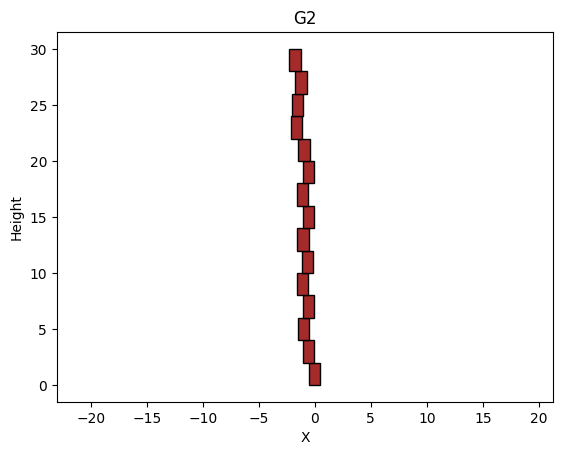

offset, thickness, direction
0.4, 1.0, 1.0
offset, thickness, direction
0.5, 1.0, -1.0
offset, thickness, direction
0.6, 1.0, -1.0
offset, thickness, direction
0.5, 1.0, -1.0
offset, thickness, direction
0.7, 1.0, -1.0
offset, thickness, direction
0.5, 1.0, -1.0
offset, thickness, direction
0.6, 1.0, 1.0
offset, thickness, direction
0.6, 1.0, -1.0
offset, thickness, direction
0.5, 1.0, -1.0
offset, thickness, direction
0.5, 1.0, 1.0
offset, thickness, direction
0.4, 1.0, 1.0
offset, thickness, direction
0.2, 1.0, 1.0
offset, thickness, direction
0.5, 1.0, -1.0
offset, thickness, direction
0.2, 1.0, 1.0
offset, thickness, direction
0.0, 1.0, 1.0


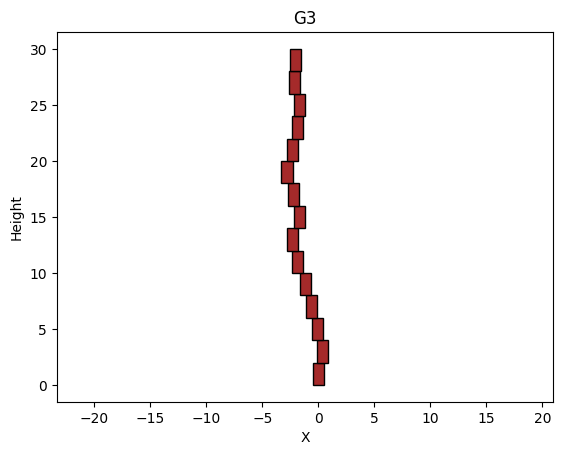

offset, thickness, direction
0.6, 1.0, -1.0
offset, thickness, direction
0.5, 1.0, 1.0
offset, thickness, direction
0.5, 1.0, 1.0
offset, thickness, direction
0.5, 1.0, 1.0
offset, thickness, direction
0.4, 1.0, 1.0
offset, thickness, direction
0.6, 1.0, -1.0
offset, thickness, direction
0.5, 1.0, -1.0
offset, thickness, direction
0.5, 1.0, -1.0
offset, thickness, direction
0.5, 1.0, -1.0
offset, thickness, direction
0.6, 1.0, -1.0
offset, thickness, direction
0.6, 1.0, -1.0
offset, thickness, direction
0.2, 1.0, 1.0
offset, thickness, direction
0.2, 1.0, 1.0
offset, thickness, direction
0.7, 1.0, -1.0
offset, thickness, direction
0.0, 1.0, 1.0


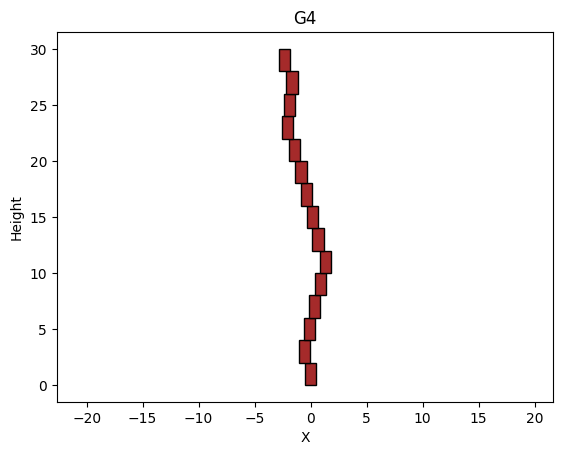

offset, thickness, direction
0.0, 1.0, 1.0
offset, thickness, direction
0.7, 1.0, -1.0


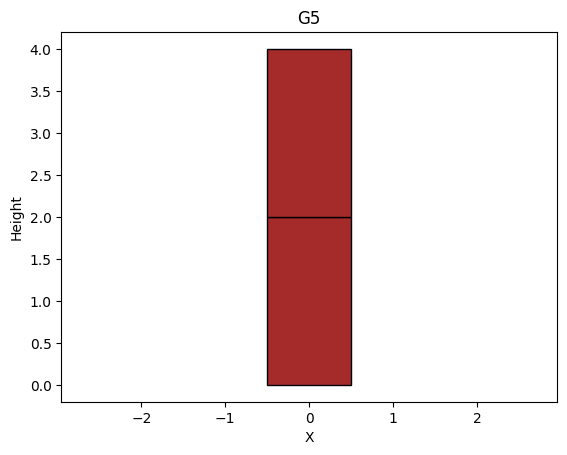

offset, thickness, direction
0.0, 1.0, 1.0
offset, thickness, direction
0.7, 1.0, -1.0


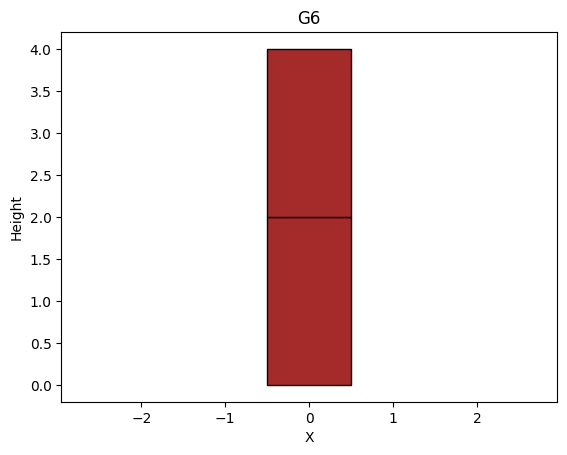

offset, thickness, direction
0.0, 1.0, 1.0
offset, thickness, direction
0.7, 1.0, -1.0


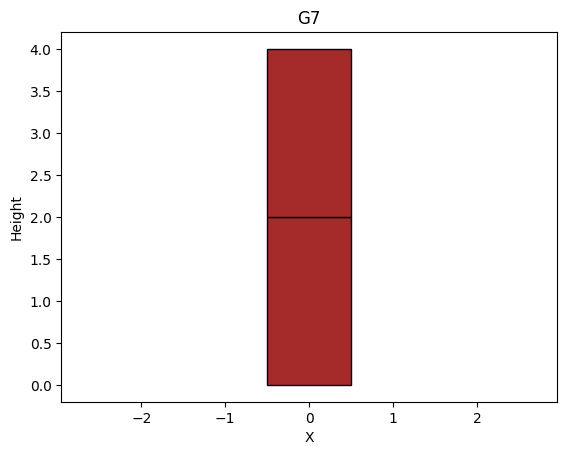

offset, thickness, direction
0.0, 1.0, 1.0
offset, thickness, direction
0.7, 1.0, -1.0


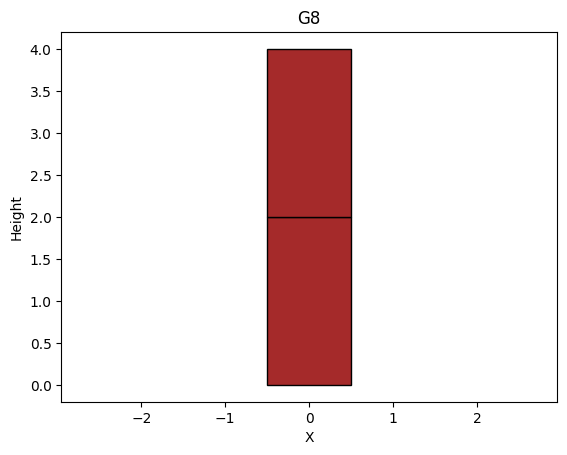

offset, thickness, direction
0.7, 1.0, -1.0
offset, thickness, direction
0.0, 1.0, 1.0


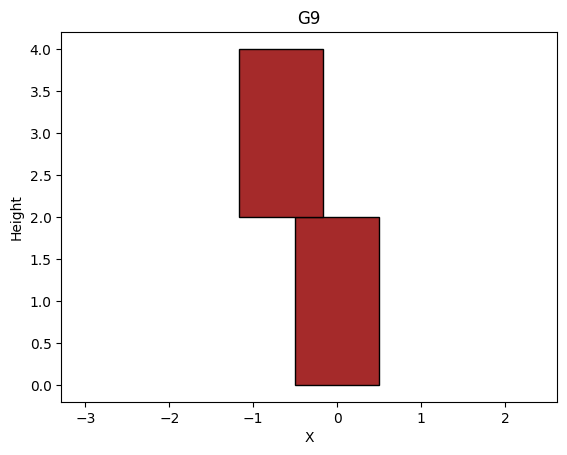

offset, thickness, direction
0.7, 1.0, -1.0
offset, thickness, direction
0.6, 1.0, 1.0
offset, thickness, direction
0.2, 1.0, -1.0
offset, thickness, direction
0.0, 1.0, 1.0


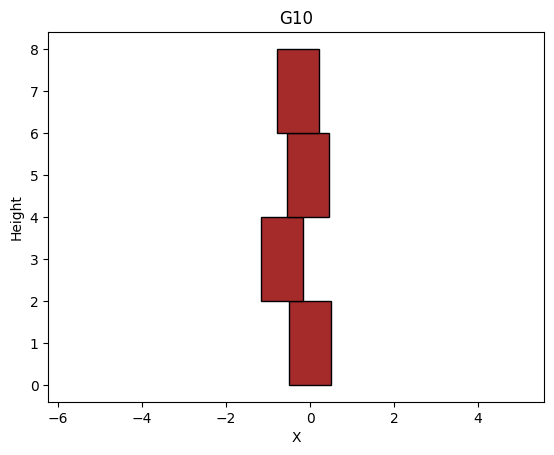

offset, thickness, direction
0.7, 1.0, -1.0
offset, thickness, direction
0.0, 1.0, 1.0


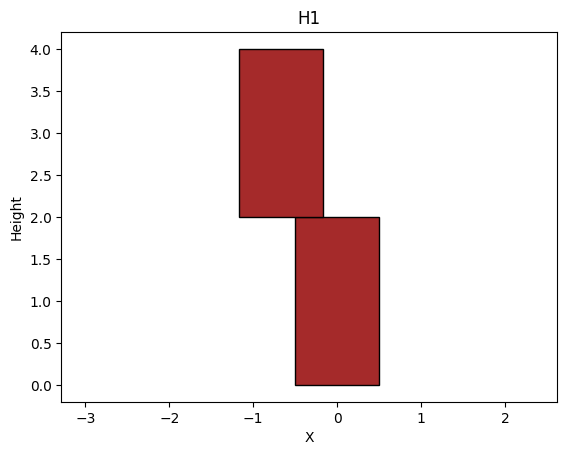

offset, thickness, direction
0.7, 1.0, -1.0
offset, thickness, direction
0.0, 1.0, 1.0


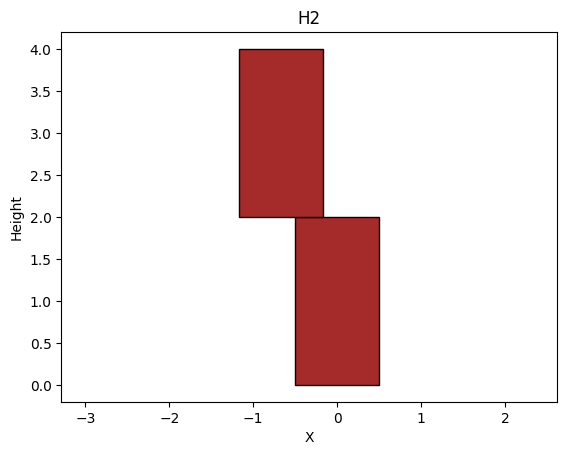

offset, thickness, direction
0.7, 1.0, -1.0
offset, thickness, direction
0.0, 1.0, 1.0


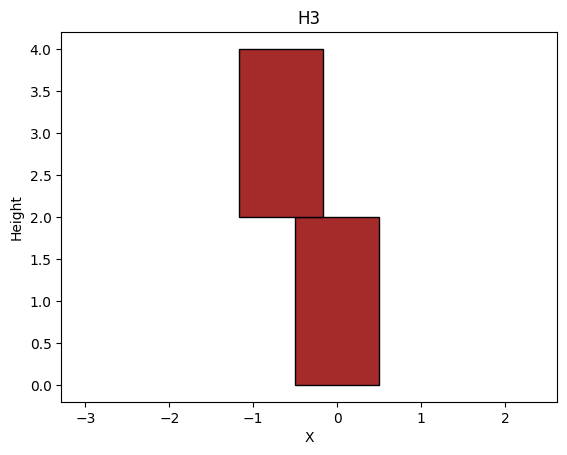

offset, thickness, direction
0.7, 1.0, -1.0
offset, thickness, direction
0.0, 1.0, 1.0


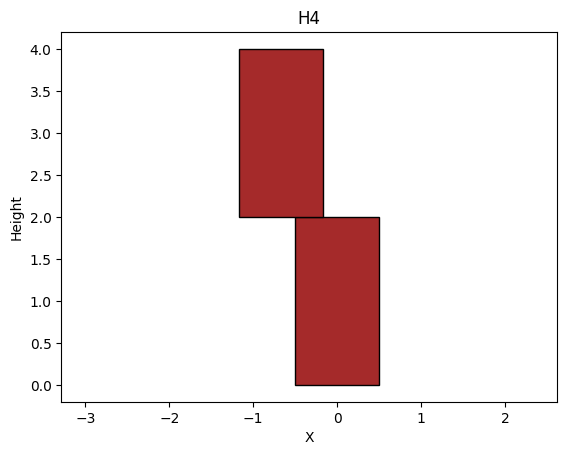

offset, thickness, direction
0.7, 1.0, -1.0
offset, thickness, direction
0.0, 1.0, 1.0


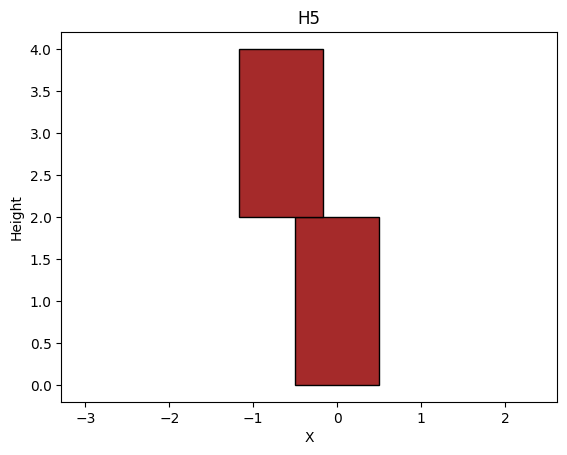

offset, thickness, direction
0.7, 1.0, -1.0
offset, thickness, direction
0.0, 1.0, 1.0


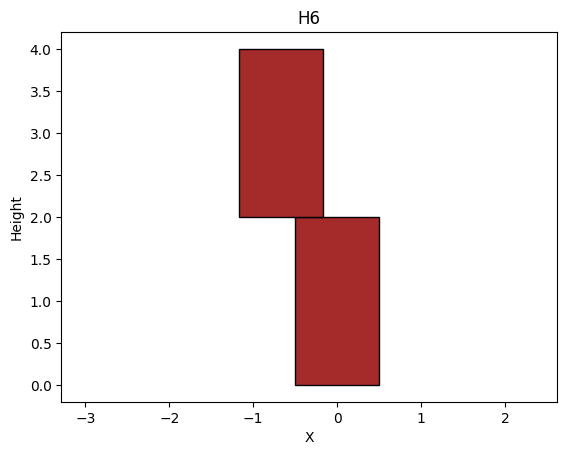

offset, thickness, direction
0.7, 1.0, -1.0
offset, thickness, direction
0.0, 1.0, 1.0


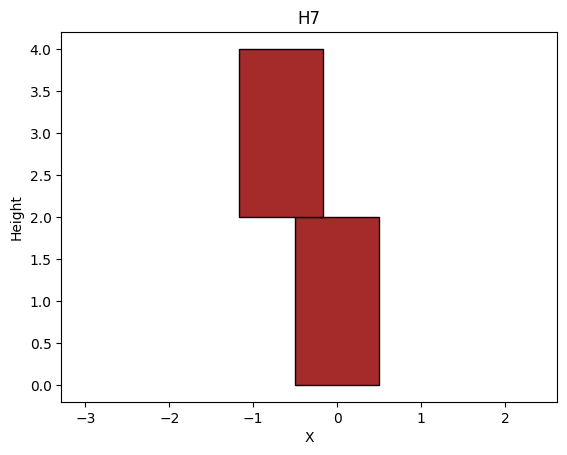

In [28]:
from matplotlib.patches import Rectangle
import os


def plot_brickwall(brick_params, title="profile"):
    # Initial
    single_brick_width = 1
    single_brick_height = 2
    current_x = -single_brick_width / 2
    current_height = 0
    fig, ax = plt.subplots()

    # normalize x
    min_x = min(brick_params, key=lambda x: x[0])[0]
    max_x = max(brick_params, key=lambda x: x[0])[0]

    # Calculate the median z value
    median_z = sorted(brick_params, key=lambda x: x[2])[len(brick_params) // 2][2]

    # Loop through the bricks
    for params in brick_params:
        # Unpack the tuple
        x, y, z = params

        # Decorate the plot with the brick parameters
        offset = (x - min_x) / (max_x - min_x) * (2 / 3)
        thickness = 1
        direction = 1 if z < median_z else -1

        if DEBUG:
            print("offset, thickness, direction")
            print(f"{offset:.1f}, {thickness:.1f}, {direction:.1f}")

        # Initialize figure and axis

        # Draw each brick
        for _ in range(int(thickness)):
            ax.add_patch(
                Rectangle(
                    (current_x, current_height),
                    single_brick_width,
                    single_brick_height,
                    facecolor="brown",
                    edgecolor="black",
                )
            )
            current_height += single_brick_height
        # Update the current position for the next brick
        current_x += offset * direction

    # Set labels and title
    ax.set_xlabel("X")
    ax.set_ylabel("Height")
    ax.set_title(title)
    # scale the plot as show all
    ax.autoscale_view()
    plt.axis("equal")
    # remove
    

    # Show the plot
    plt.show()
    # save plot to file create if not
    if not os.path.exists('output'):
        os.makedirs('output')
    fig.savefig(f'output/{title}.png')
    plt.close(fig)
    


with open(f'data.txt', 'r') as f:
    #init plot
    nameX='A'
    nameY=2
    for line in f:
        
        # remove first and last character
        line = line[1:-2]
        # split string into list
        line = line.split(')(')
        # convert string to tuple
        list_of_rgb = [tuple(map(int, x.split(','))) for x in line]
        
        plot_brickwall(list_of_rgb, f'{nameX}{nameY}')
        if nameY>=10:
            nameY=1
            nameX=chr(ord(nameX)+1)
        else:
            nameY+=1
        
        


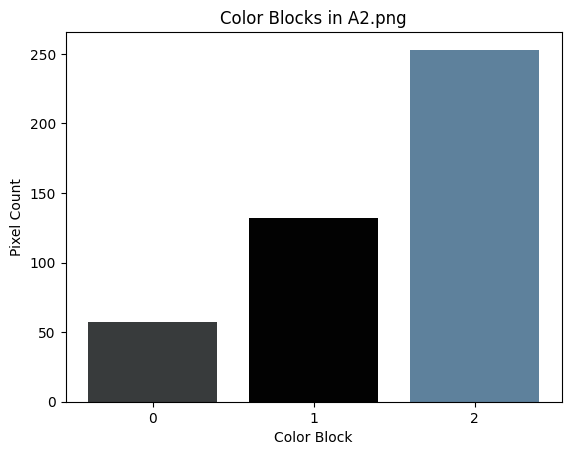

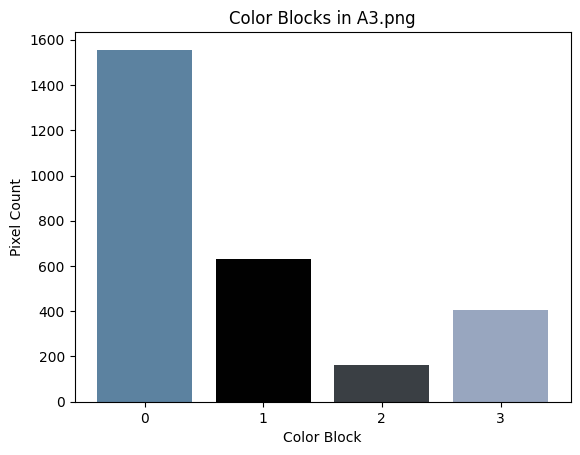

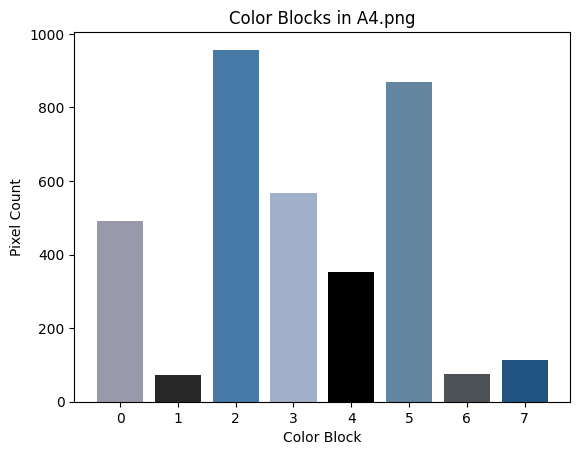

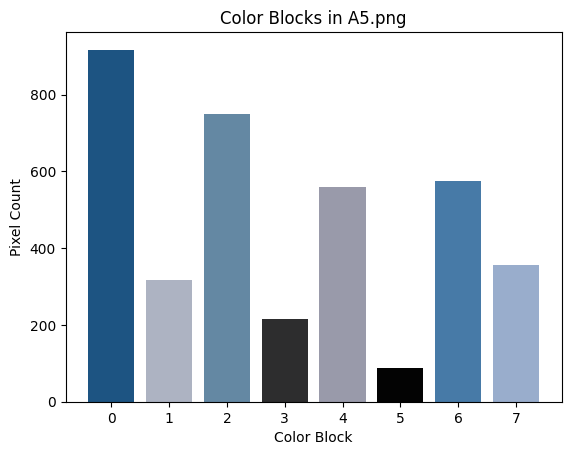

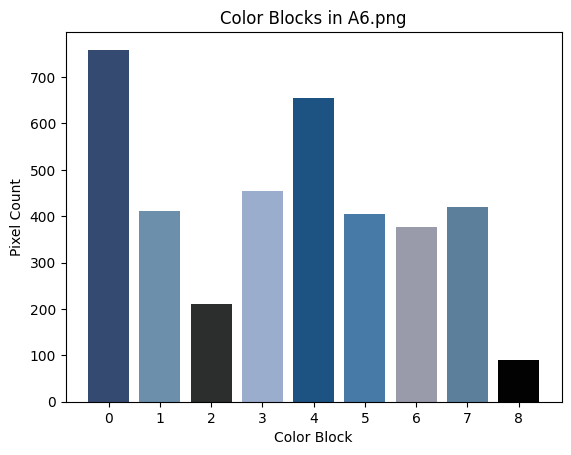

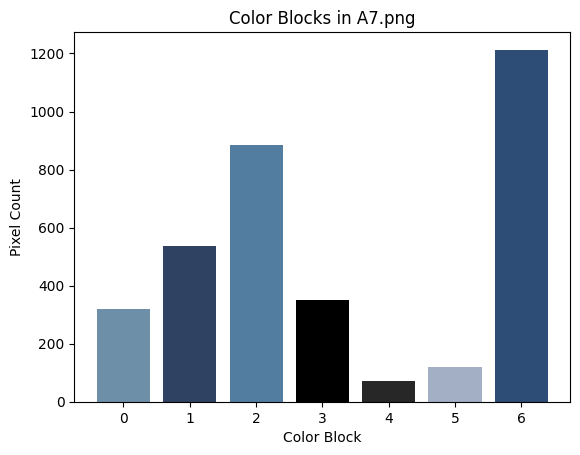

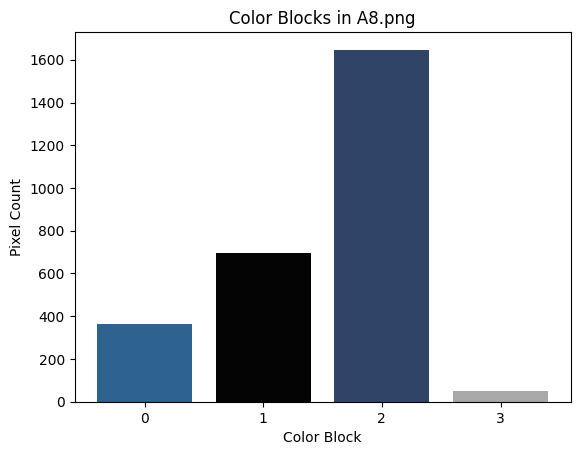

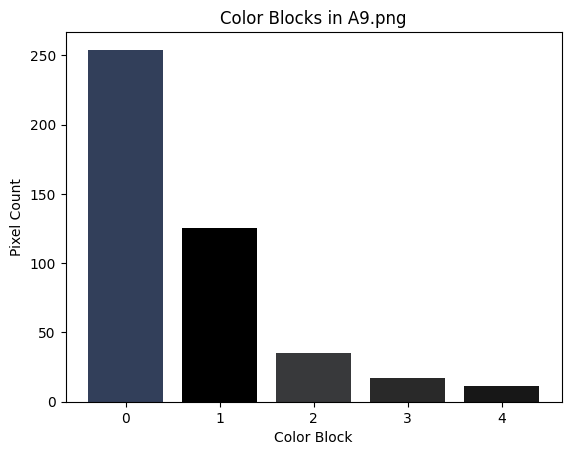

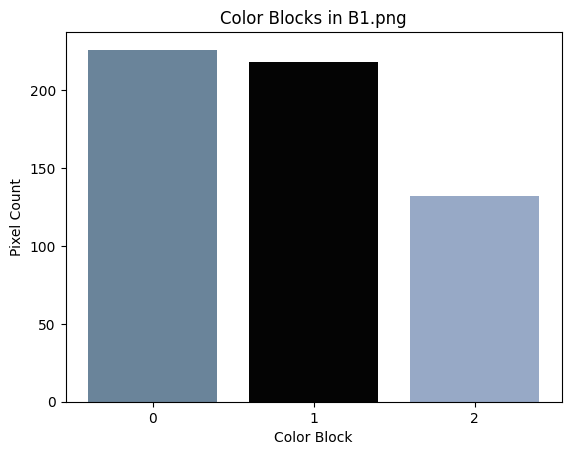

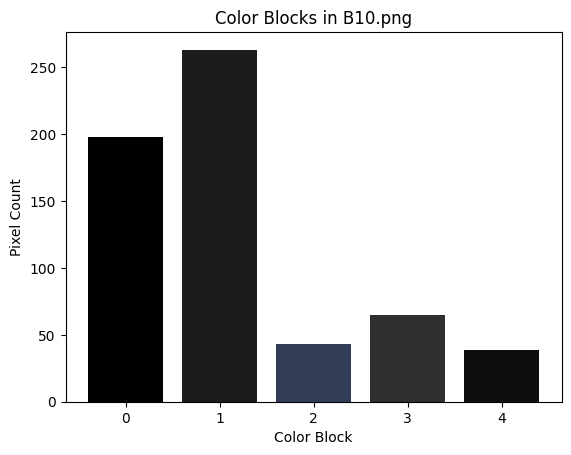

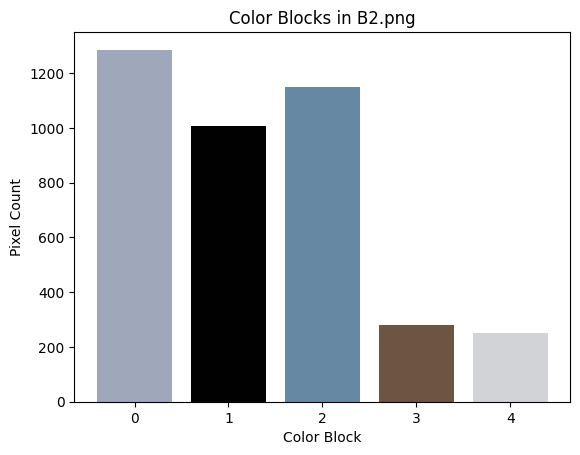

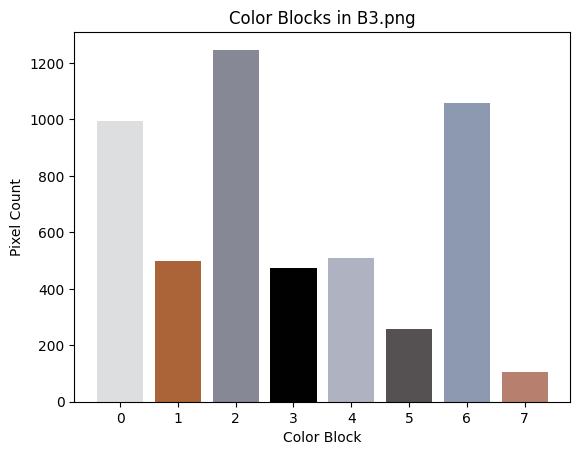

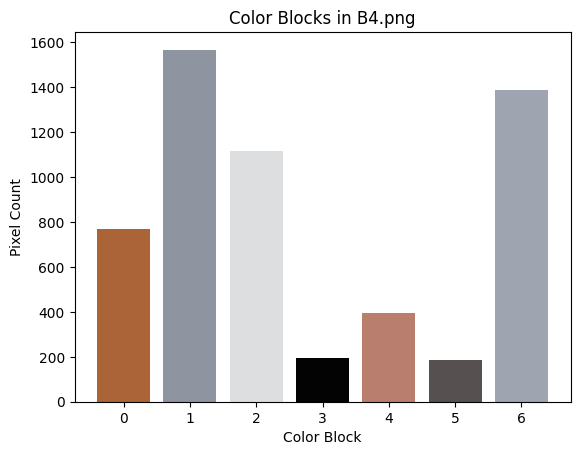

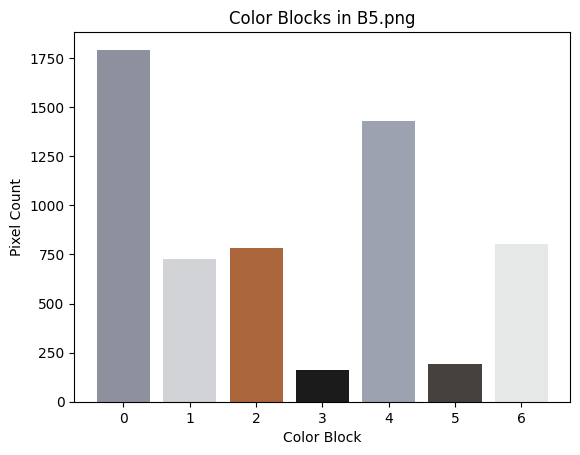

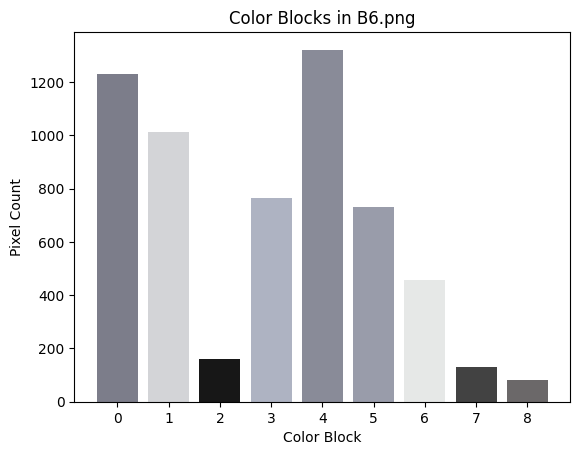

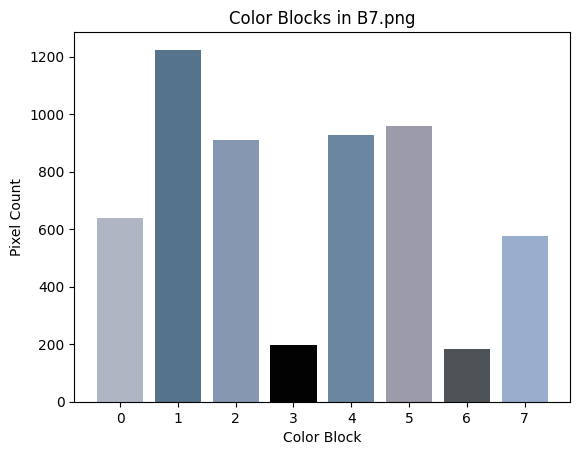

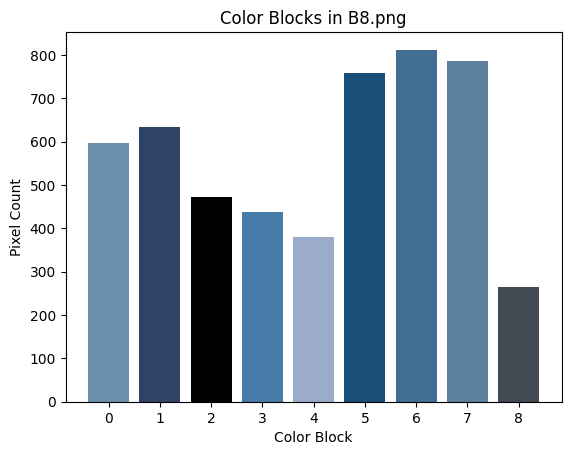

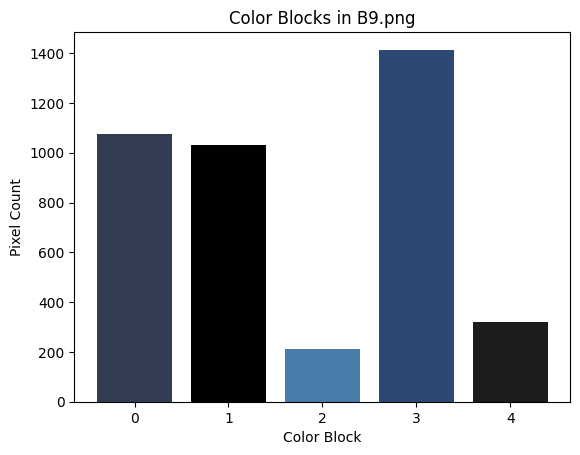

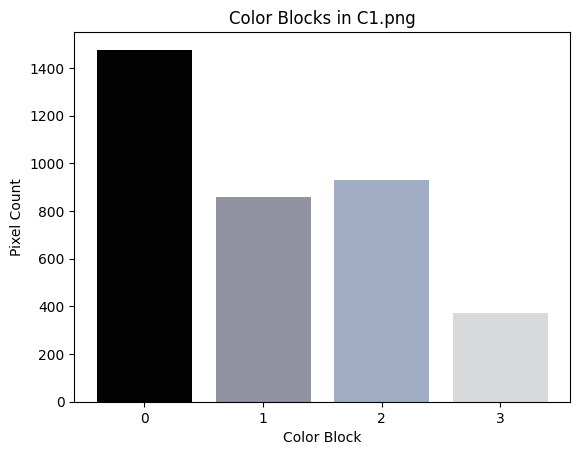

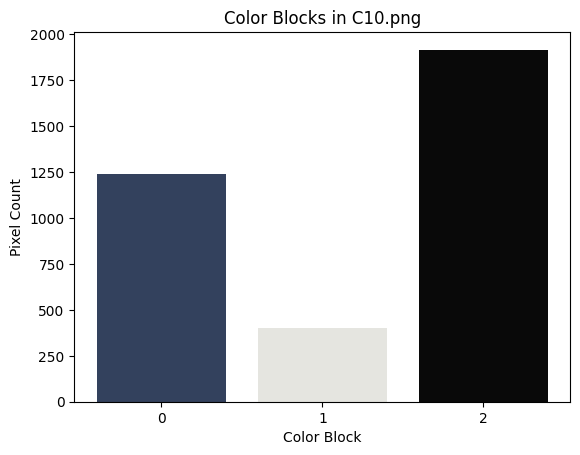

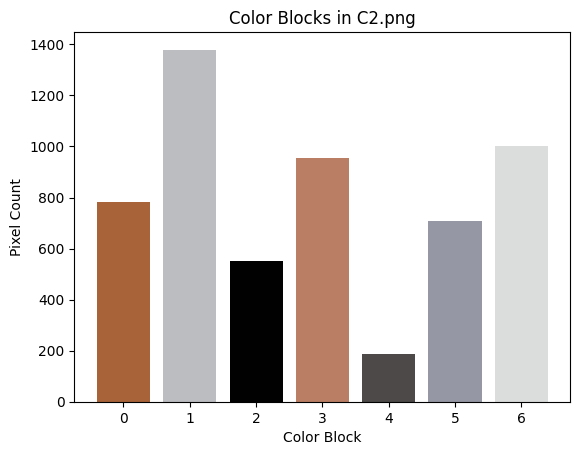

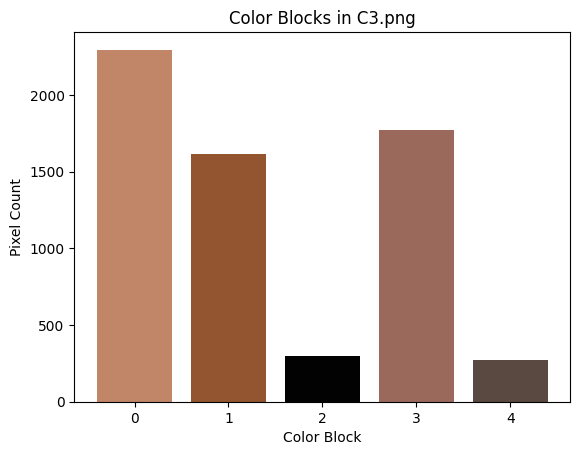

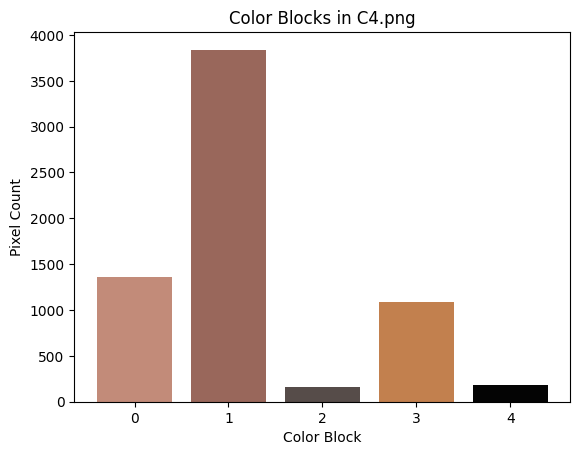

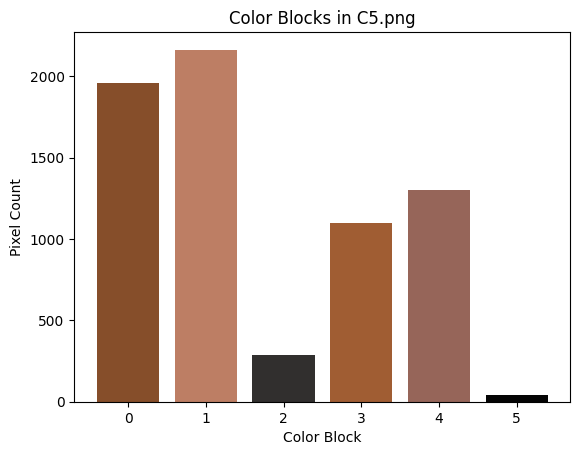

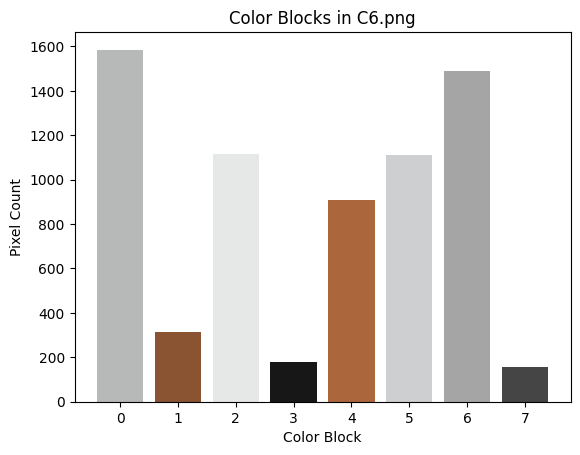

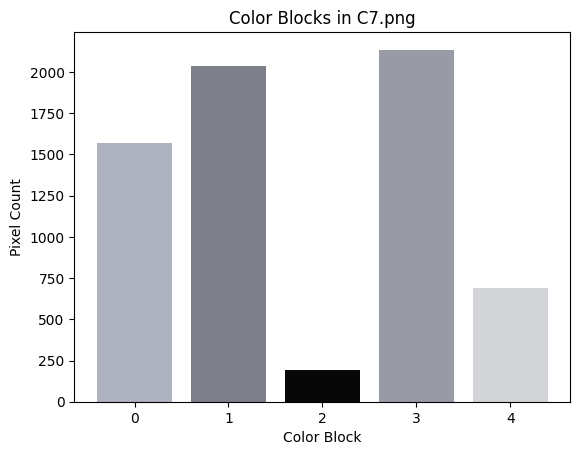

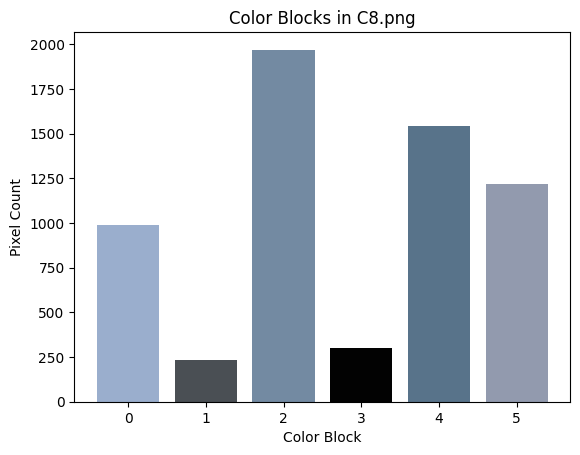

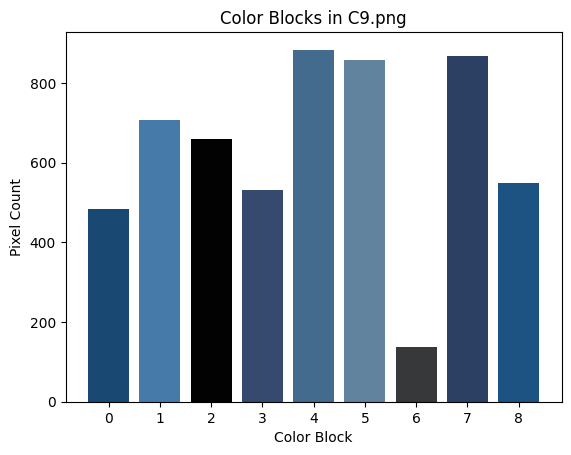

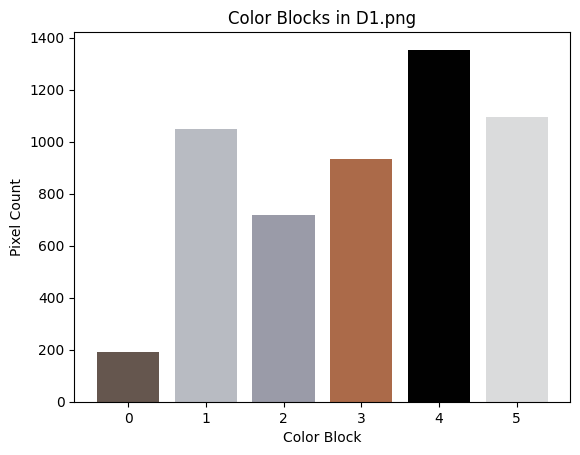

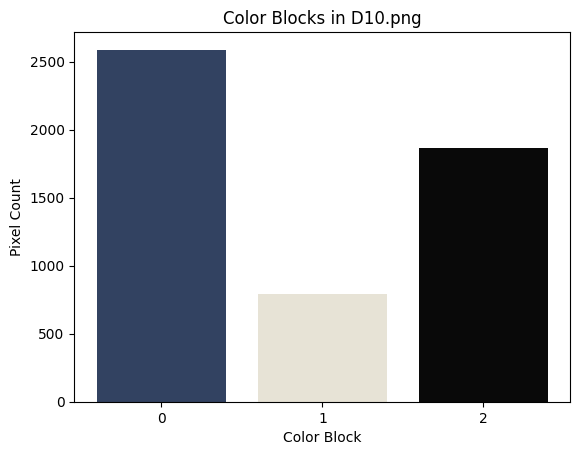

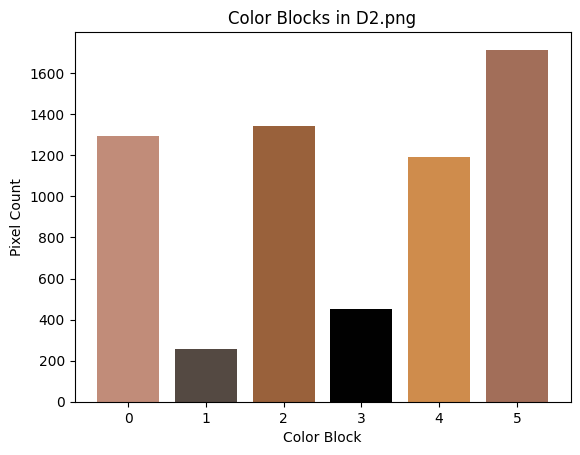

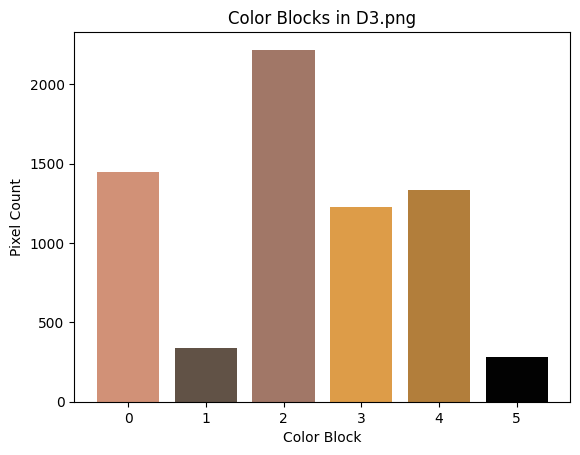

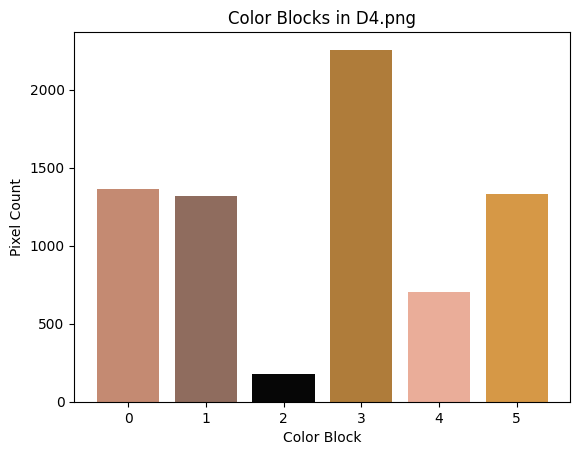

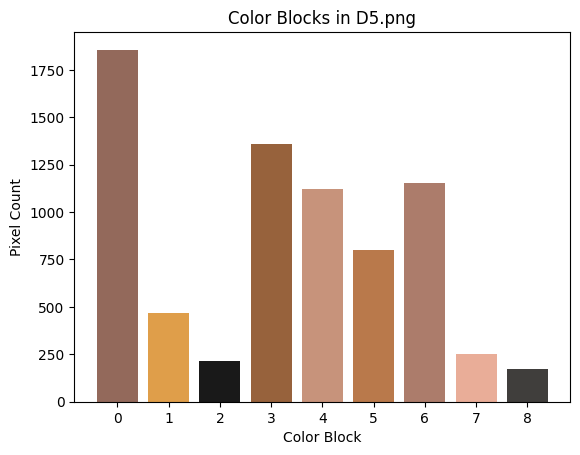

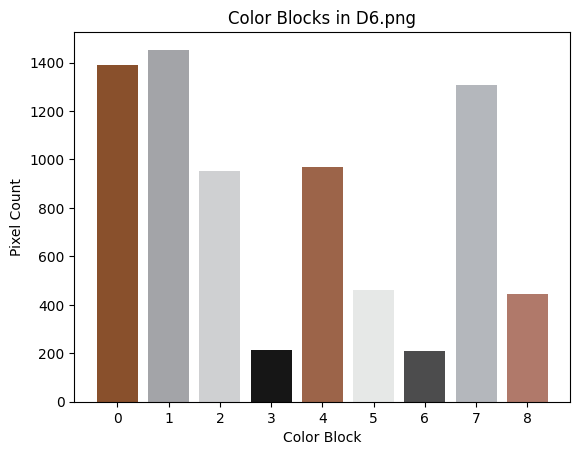

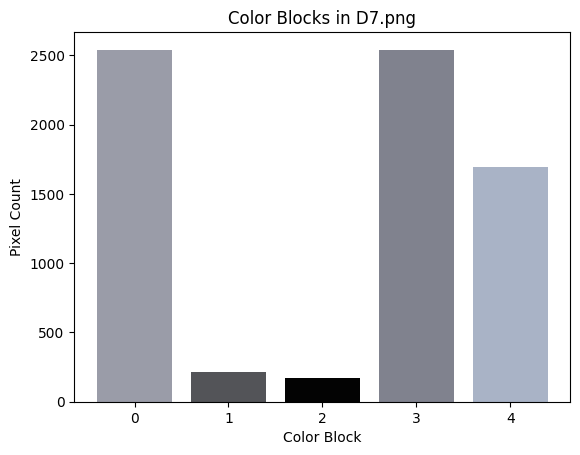

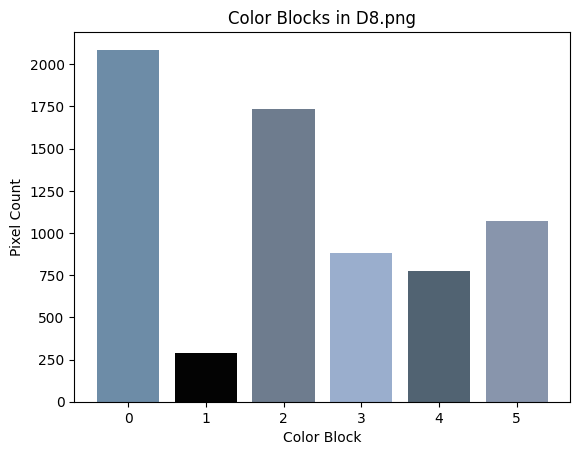

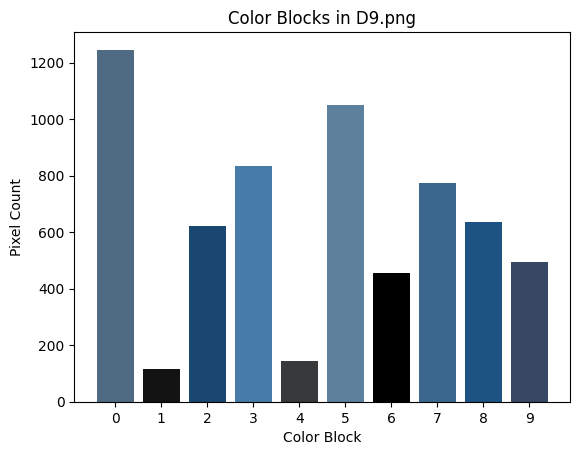

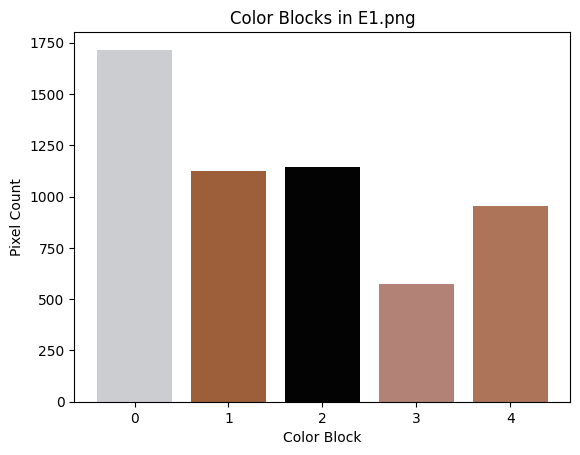

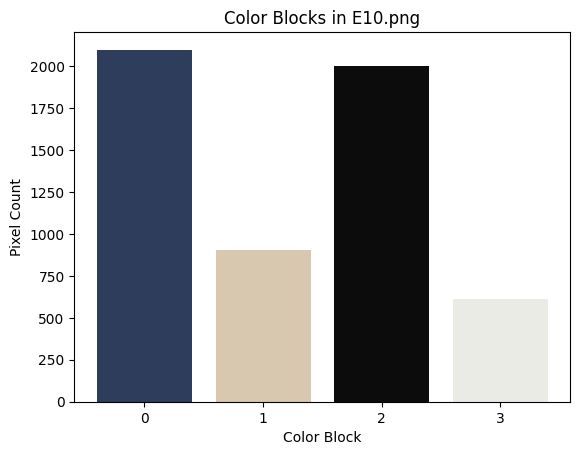

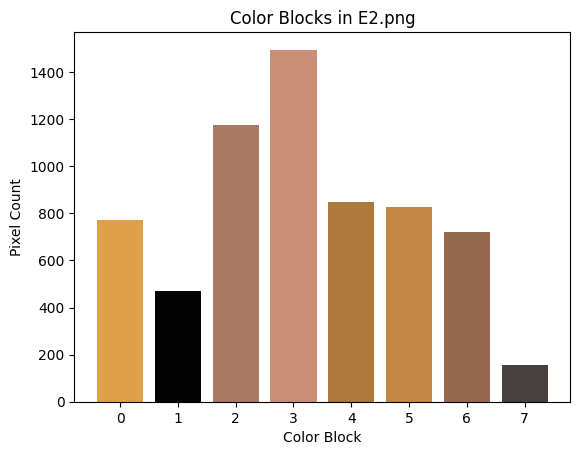

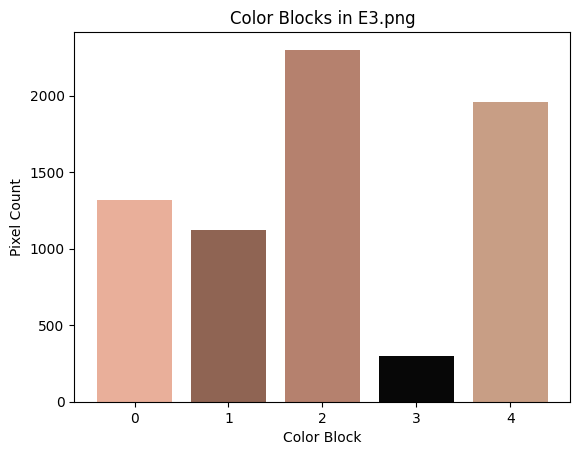

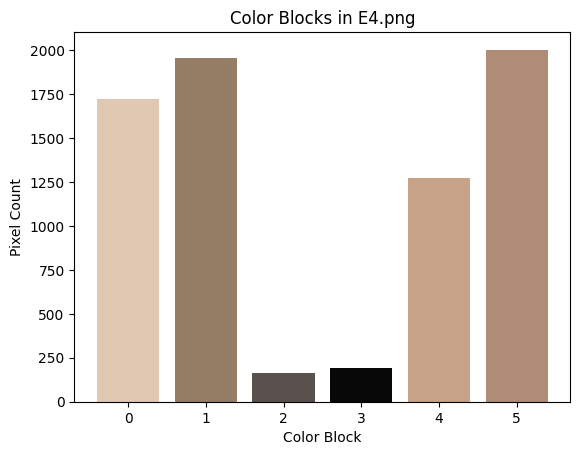

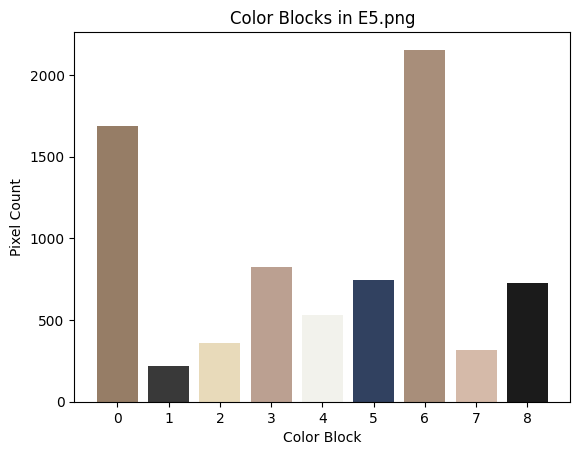

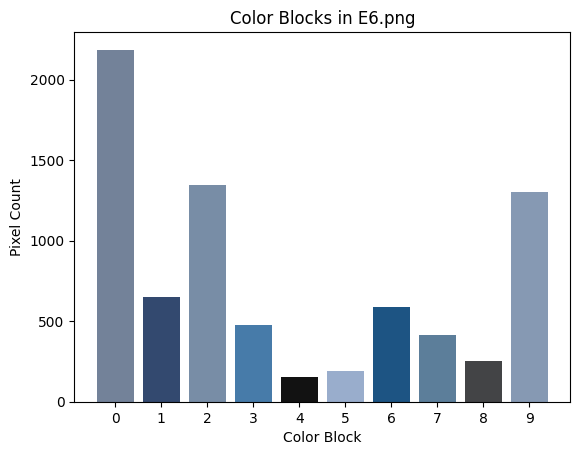

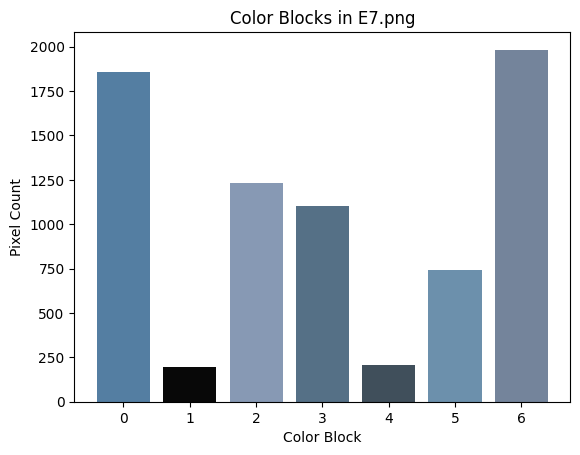

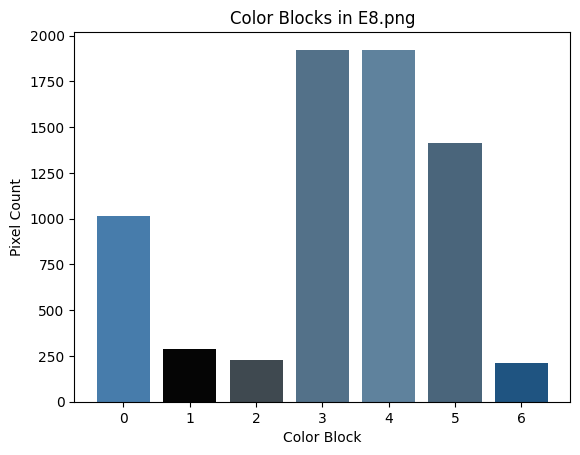

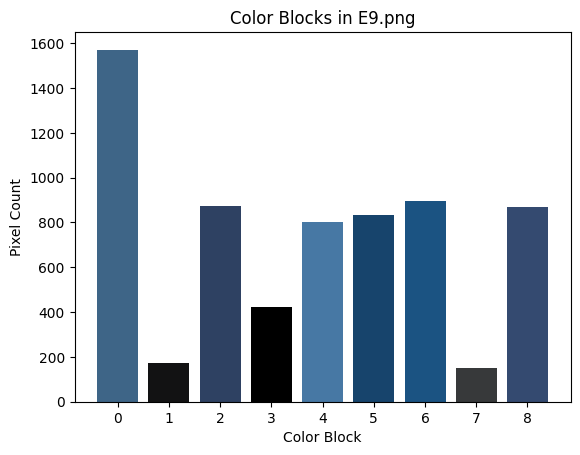

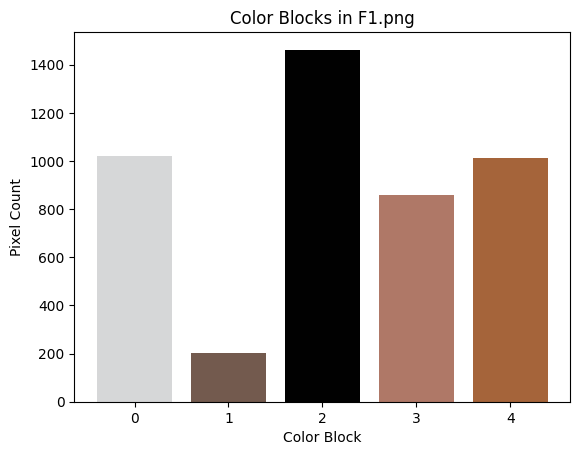

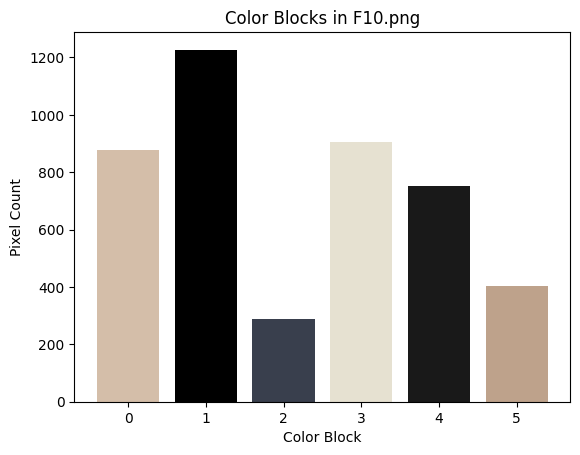

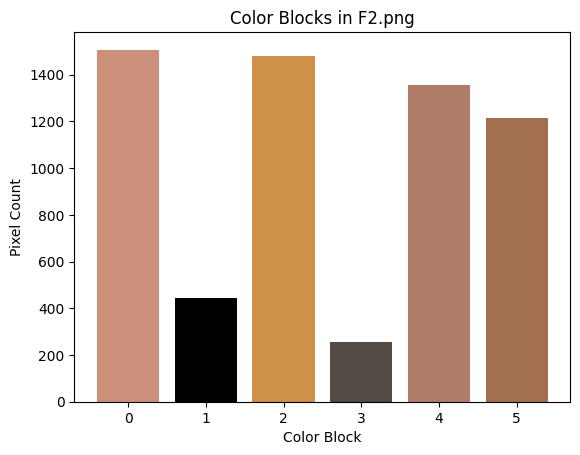

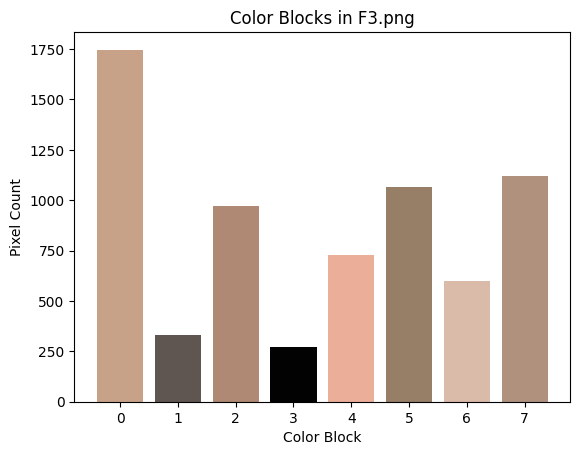

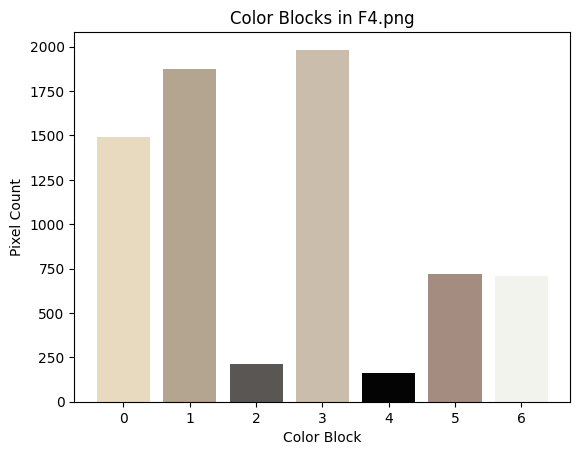

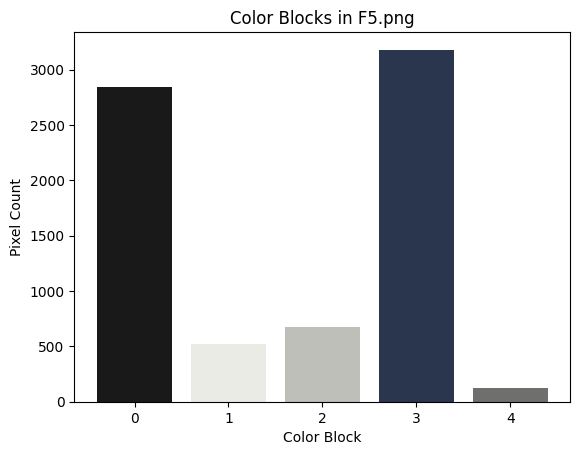

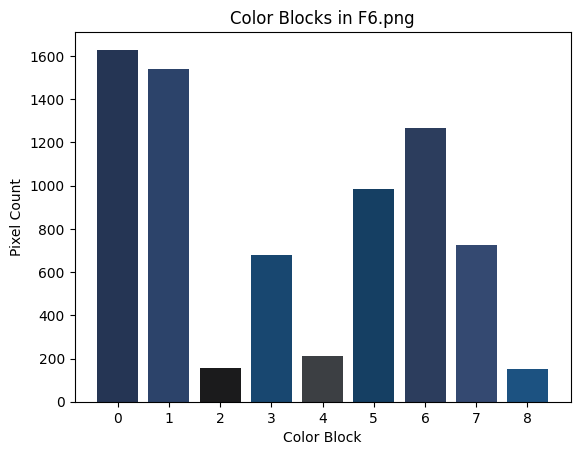

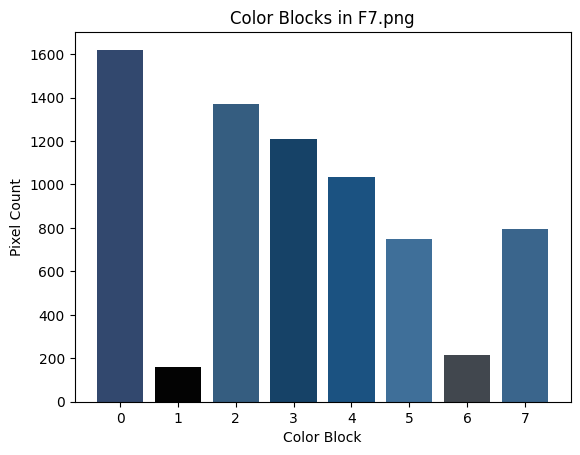

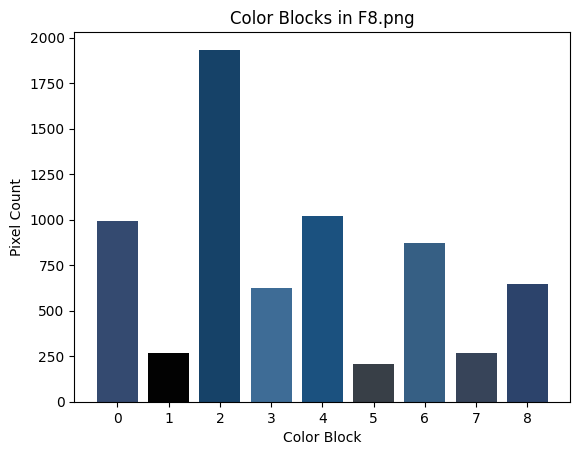

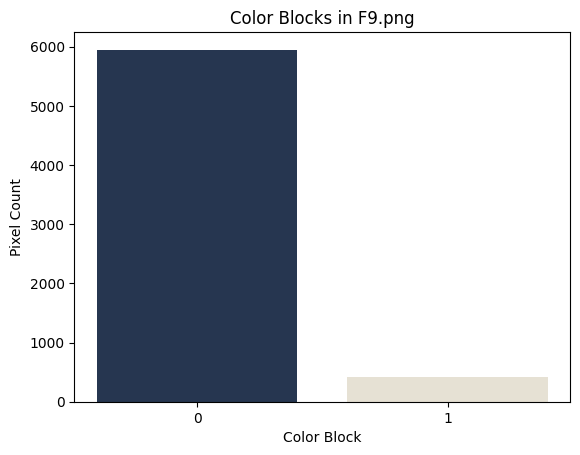

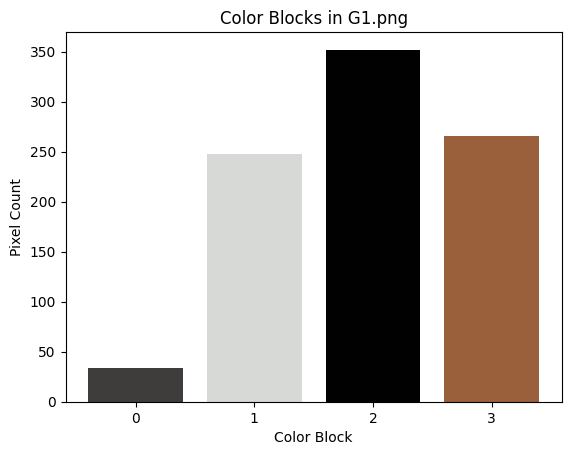

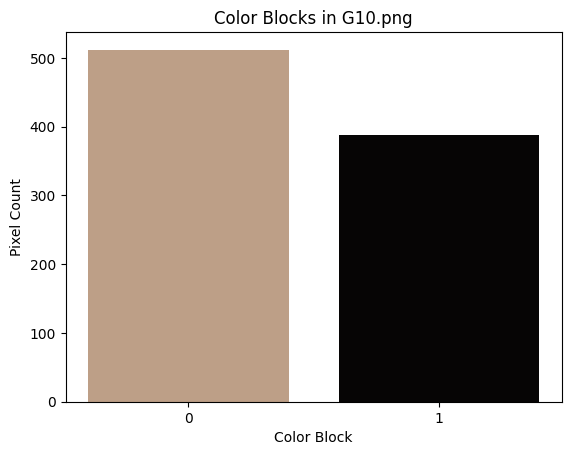

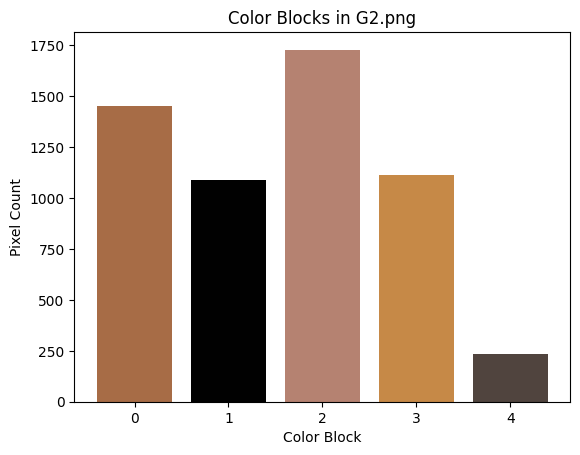

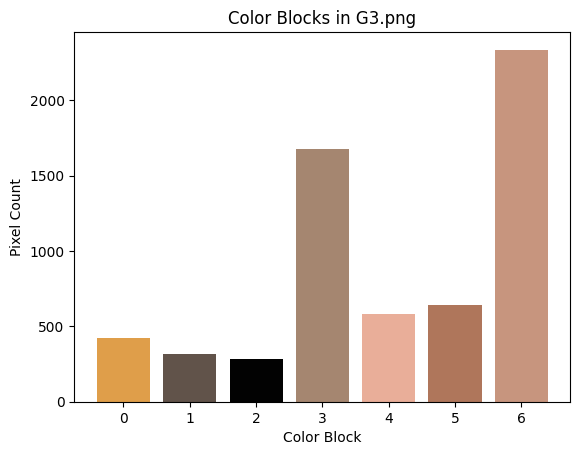

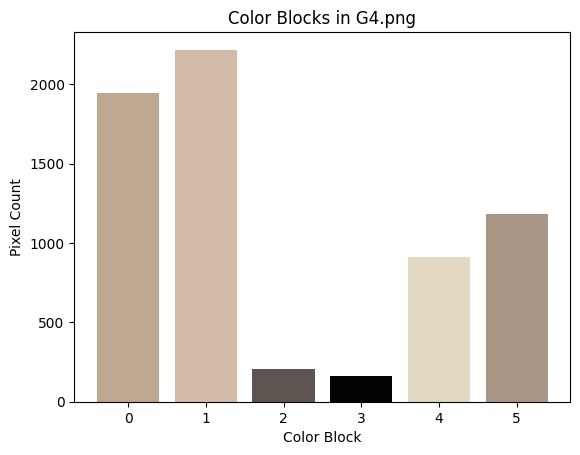

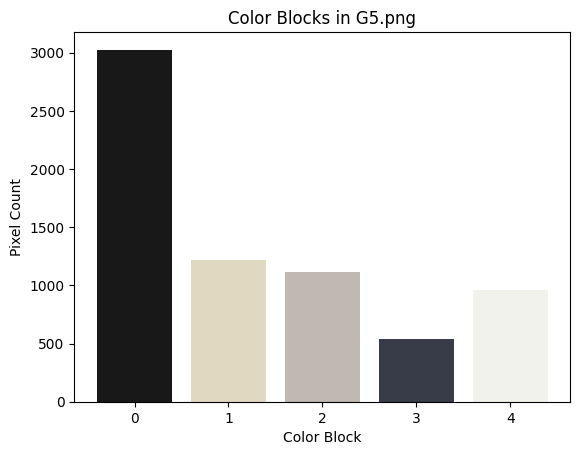

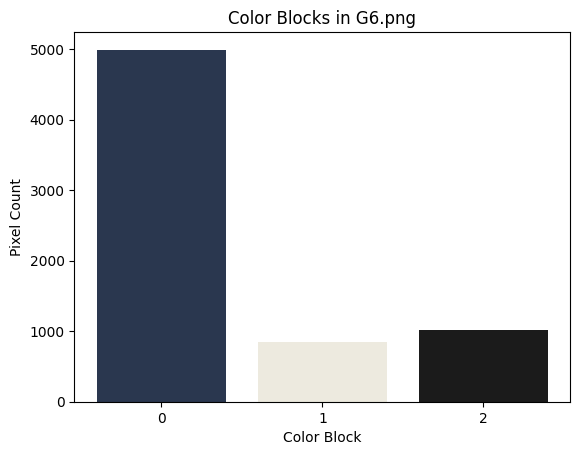

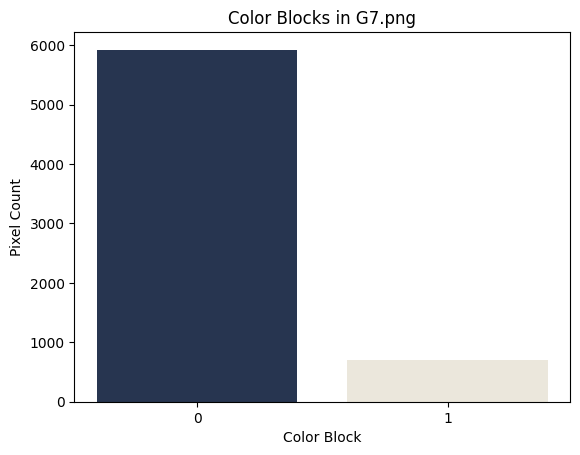

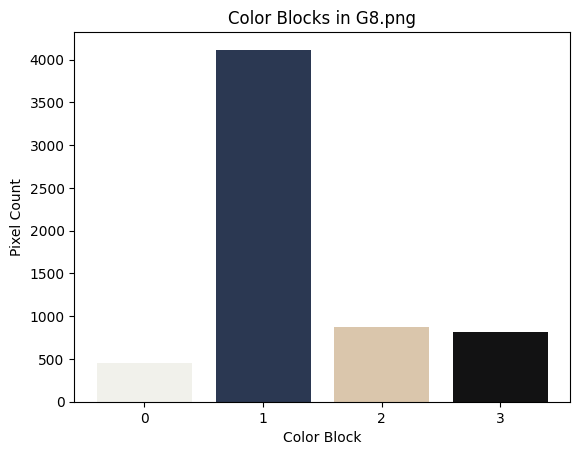

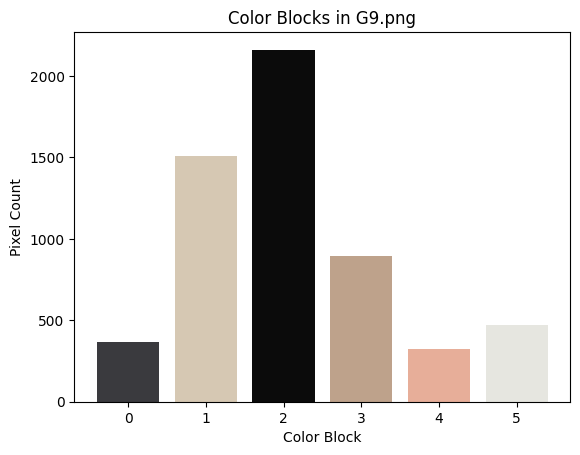

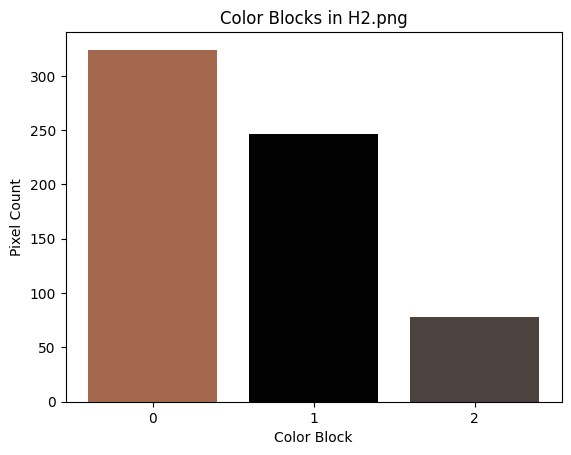

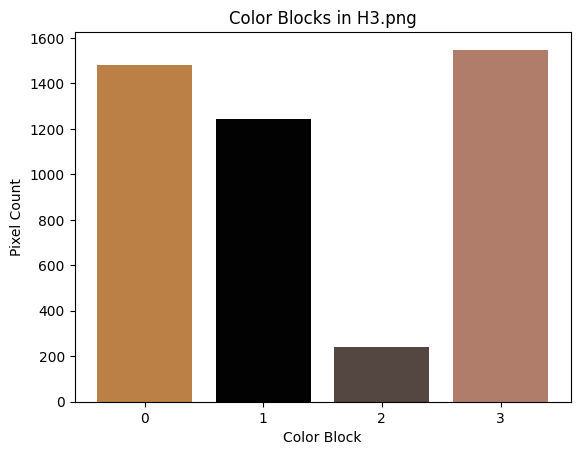

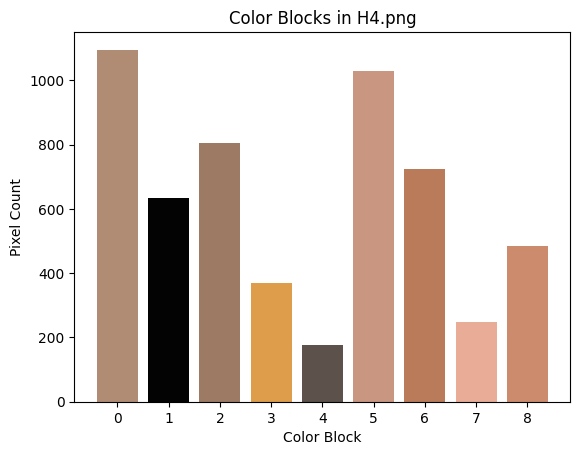

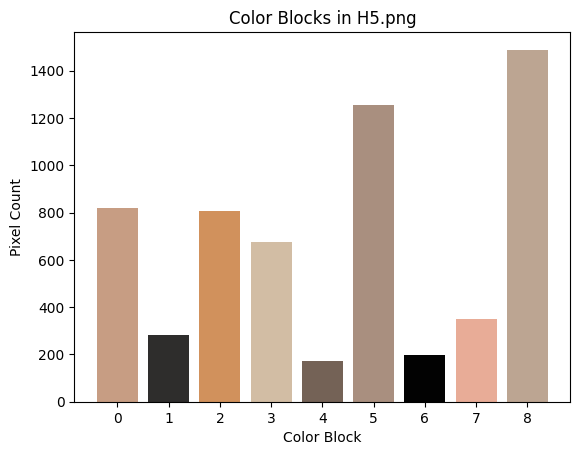

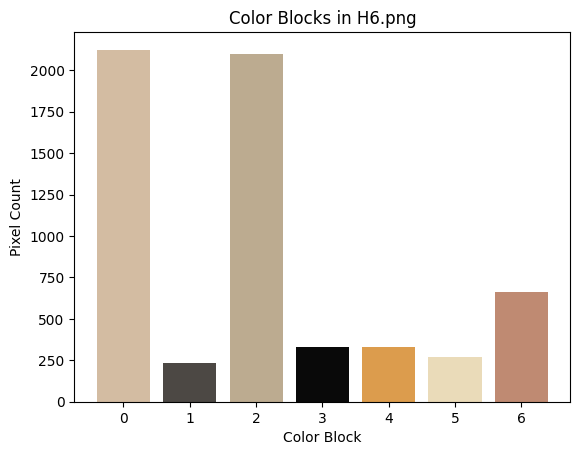

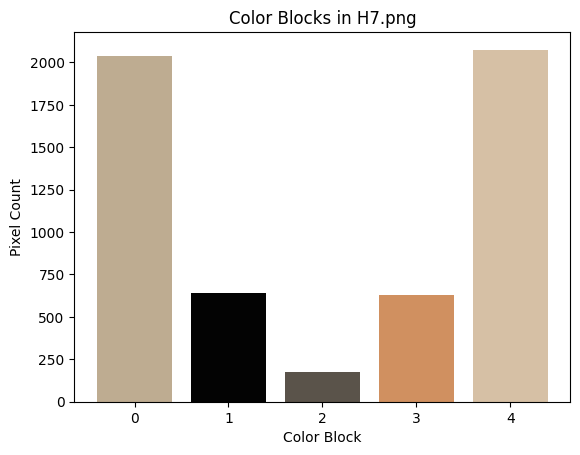

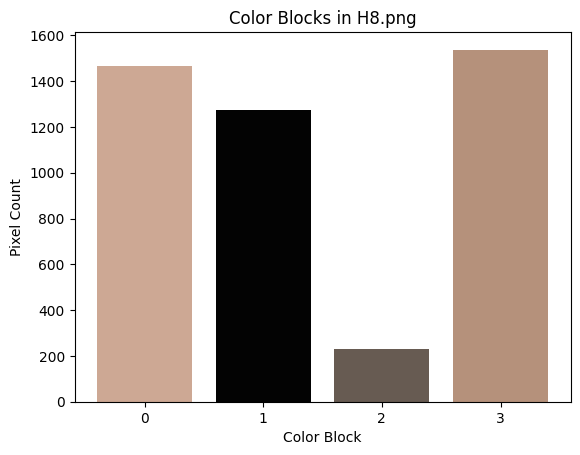

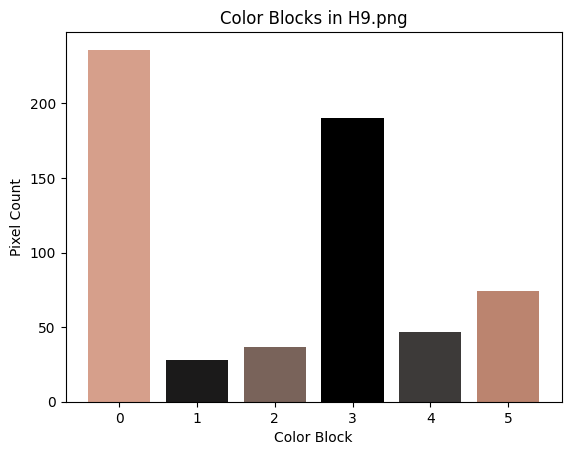

In [29]:
from skimage import color
from scipy.signal import find_peaks
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans


def estimate_color_blocks(image_path, histogram_bins=50, peak_threshold=0.05):
    # Load the image
    image = Image.open(image_path)
    np_image = np.array(image)

    # Convert to RGB if RGBA
    if np_image.shape[-1] == 4:
        np_image = np_image[:, :, :3]

    # Flatten the image and normalize pixel values
    pixels = np_image.reshape((-1, 3)) / 255.0

    # Compute the histogram for each color channel
    hist, _ = np.histogramdd(pixels, bins=(histogram_bins, histogram_bins, histogram_bins))

    # Sum the histograms and normalize
    hist_sum = np.sum(hist, axis=(1, 2))
    hist_sum_normalized = hist_sum / np.max(hist_sum)

    # Find peaks in the histogram to estimate color blocks
    peaks, _ = find_peaks(hist_sum_normalized, height=peak_threshold)
    num_color_blocks = len(peaks)

    return max(num_color_blocks, 1)  # Ensure at least one cluster


def cluster_and_plot_colors(image_path):
    image = Image.open(image_path)
    np_image = np.array(image)

    # Convert to RGB if RGBA
    if np_image.shape[-1] == 4:
        np_image = np_image[:, :, :3]

    # Normalize pixel values
    pixels = np_image.reshape((-1, 3)) / 255.0

    # Estimate the number of color blocks
    num_clusters = estimate_color_blocks(image_path)

    # Apply K-means clustering
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    labels = kmeans.fit_predict(pixels)
    cluster_centers = kmeans.cluster_centers_

    # Plot the results
    unique_labels = np.unique(labels)
    for label in unique_labels:
        count = np.sum(labels == label)
        color = cluster_centers[label]
        plt.bar(str(label), count, color=color)

    plt.title(f'Color Blocks in {os.path.basename(image_path)}')
    plt.xlabel('Color Block')
    plt.ylabel('Pixel Count')
    plt.show()


# Define the directory and process PNG files
directory = './temp'  # Update this path
png_files = sorted([f for f in os.listdir(directory) if f.endswith('.png')])

for png_file in png_files:
    image_path = os.path.join(directory, png_file)
    cluster_and_plot_colors(image_path)
